## let's check three things in the fMRI data
1. tSNR (of preprocessed data)
2. left > right button presses t-test
3. Physiological noise regression F-tests

In [1]:
import glob
import os
import re
import shutil
import random
import string

#import mkl
#mkl.set_num_threads(4)   # by default, use 4 threads for NP
import numpy as np
import pandas as pd

import nilearn
from nilearn import plotting, image
from nilearn.input_data import NiftiMasker
import nibabel as nib
from nipype.interfaces import ants
#import nighres

# simple modeling
from nilearn.glm.first_level import FirstLevelModel #nilearn must be -v >= 0.7.0

import subprocess
import json
import multiprocessing as mp
from functools import partial
import joblib
from joblib import Parallel, delayed

from utils import apply_warp

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.__version__

'0.13.2'

In [16]:
def find_rois(sub, atlas_name='ATAG', space='T1w'):
    if atlas_name == 'ATAG':
        if space == 'MNI152NLin2009cAsym' or space == 'mni':
            ### Rois in MNI09c-space
            mask_dir='/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym_res-1p5'
            fns = sorted(glob.glob(mask_dir + '/space-*'))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_res-1p5_label-(?P<label>[a-zA-Z0-9]+)_probseg_def-img.nii.gz', fn).groupdict()['label'] for fn in fns]
        else:
            mask_dir = f'../derivatives/masks_atag_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
            fns = sorted(glob.glob(mask_dir))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>[a-zA-Z0-9]+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'MASSP':
        mask_dir = f'../derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'thalamus':
        mask_dir = f'../derivatives/masks_thal_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>.*).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'WM-rep':
        mask_dir = f'../derivatives/masks_WM-rep_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>.*).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'hippSubfield':
        mask_dir = f'../derivatives/masks_hippSubfields_freesurfer/sub-{sub}/hipp_subFields_space_T1w-desc_func/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'LC':
        mask_dir = f'../derivatives/mt_tfl/sub-{sub}/LC_mask_T1-w_space/sub-{sub}_LC_mask_space-T1w_desc-mask-*_V4_excl.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]
    # MASSP27 ATLAS        
    elif atlas_name == 'MASSP27':
        mask_dir = f'../derivatives/masks_massp27_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'rsFC_thres-40':
        mask_dir = f'../derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]
    roi_dict = dict(zip(names, fns))

    return roi_dict

def load_atlas(sub, atlas_name='rsFC_thres-40', space='T1w'):
    from nilearn import image
    
    roi_dict = find_rois(sub, atlas_name, space)
    combined = image.concat_imgs(roi_dict.values())
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
            
    roi_atlas = AttrDict({'maps': combined,
                          'labels': roi_dict.keys()})
    
    return roi_atlas

In [3]:
# sub = '011'
# boldref = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
# nilearn.plotting.plot_prob_atlas(load_atlas(sub).maps, bg_img=boldref)

# 1. tSNR

In [17]:
# function for tSNR
def high_pass(nii, verbose=False, mask=None):
#     print('Highpass-filtering')
    t_r = nii.header['pixdim'][4]
    if mask is not None:
        hp_masker = NiftiMasker(mask, high_pass=1./128, t_r=t_r)
    else:
        hp_masker = NiftiMasker(high_pass=1./128, t_r=t_r)
    
    # Generate & fit NiftiMasker
    hp_data = hp_masker.fit_transform(nii)
    
    # back to brain space
    inver = hp_masker.inverse_transform(hp_data)

    # add mean of timeseries per voxel back
    highpassed_data = inver.get_fdata() + np.mean(nii.get_fdata(), 3)[:,:,:,np.newaxis]
    highpassed_img = nib.Nifti1Image(highpassed_data, inver.affine, header=nii.header)
    
    return highpassed_img

def make_tsnr_image(nii, exclude_volumes=4):
    ''' exclude_volumes: how many (non-steady state) volumes at the beginning of the run should be excluded?'''
#     print('Calculating tSNR')
    mean_ = nilearn.image.math_img('nii[:,:,:,{}:].mean(-1)'.format(exclude_volumes), nii=nii)
    std_ = nilearn.image.math_img('nii[:,:,:,{}:].std(-1)'.format(exclude_volumes), nii=nii)
    tsnr = nilearn.image.math_img('nii[:,:,:,{}:].mean(-1)/nii[:,:,:,{}:].std(-1)'.format(exclude_volumes,exclude_volumes), nii=nii)
    
    return tsnr, mean_, std_

## extracting value from mask
def get_roi_weighted_average(nii, atlas):
    data = nii.get_fdata()
    
    # identify voxels that shouldn't be weighted: cnr/tsnr can't be <0, >1000, or nan.
    # these can arise, mostly at the edges of the brain, due to numerical issues (T2* estimation, division by small noise, etc)
    bad_voxel_idx = (data < 0) | (data > 100000) | np.isnan(data)
    
    # set to 0 in data
    data[bad_voxel_idx] = 0
    
    out = pd.Series(index=pd.Index(atlas.labels))
    for mask_id in np.arange(atlas.maps.shape[-1]):
        # get in mask
        mask_label = [x for x in atlas.labels][mask_id]

        this_mask = image.index_img(atlas.maps, mask_id).get_fdata()
        this_mask[bad_voxel_idx] = 0  # bad values, don't weigh these
        this_mask[this_mask<0.01] = 0  # prevent negative weights
        
        if this_mask.sum() > 0:
            val_weighted = np.average(data, weights=this_mask)  # inf * 0 = np.nan -> manually set np.nans to 0
        else:
            val_weighted = 0
        out[mask_label] = val_weighted
    return out

In [11]:
def get_tsnr(fn, overwrite_hp=False, overwrite_tsnr=False):
    regex = re.compile('.*sub-(?P<sub>\d+)_ses-(?P<ses>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_space-T1w_desc-preproc_bold.*')
    gd = regex.match(fn).groupdict()
#     print(fn)
#     print(gd)
    brain_mask = nib.load(fn.replace('preproc_bold', 'brain_mask'))

    # has this file been highpassed?
    hp_save_fn = fn.replace('fmriprep/fmriprep', 'high_passed_func')
    if os.path.exists(hp_save_fn) and not overwrite_hp:
        hp_data = nib.load(hp_save_fn)
    else:
        nii = nib.load(fn)
        print('Highpass-filtering {}'.format(fn.split('/')[-1]))
        hp_data = high_pass(nii, mask=brain_mask)
        os.makedirs(os.path.dirname(hp_save_fn), exist_ok=True)
        hp_data.to_filename('../derivatives/high_passed_func/sub-{}/ses-{}/func/{}'.format(gd['sub'], gd['ses'], os.path.basename(fn)))

    # Has tsnr nii already been created?
    tsnr_save_fn = fn.replace('fmriprep/fmriprep', 'tsnr').replace('desc-preproc_bold', 'desc-tsnr')
    if os.path.exists(tsnr_save_fn) and not overwrite_tsnr:
        tsnr = nib.load(tsnr_save_fn)
    else:
        print('Calculating tSNR of {}'.format(tsnr_save_fn.split('/')[-1]))
        tsnr, mean_, std_ = make_tsnr_image(hp_data)
        os.makedirs(os.path.dirname(tsnr_save_fn), exist_ok=True)
        
        tsnr.to_filename(tsnr_save_fn)
        mean_.to_filename(tsnr_save_fn.replace('-tsnr', '-mean'))
        std_.to_filename(tsnr_save_fn.replace('-tsnr', '-std'))
    
    # extract values and save to csv
    for atlas_name in ['rsFC_thres-40']: # ['MASSP27', 'LC', 'hippSubfield']:#['MASSP', 'ATAG', 'thalamus']:
        fn_out = f'../derivatives/tsnr/sub-{{sub}}/ses-{{ses}}/func/sub-{{sub}}_ses-{{ses}}_task-{{task}}_run-{{run}}_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'.format(**gd)
        
        if os.path.exists(fn_out) and not overwrite_tsnr:
            continue
        
        try:
            atlas = load_atlas(sub=gd['sub'], atlas_name=atlas_name, space='T1w')
        except:
            # not all subs have MASSP labels yet
            
            continue
        print(gd)
#         if not (tsnr.affine == atlas.maps.affine).all():
#             print('Atlas and tSNR map do not have the same affine, rerun highpassing & tsnr creation! {}'.format(fn))
#             return atlas, tsnr
#             break
#         print(atlas_name)
        tsnr_table = pd.DataFrame(get_roi_weighted_average(tsnr, atlas=atlas)).T
        tsnr_table['subject'] = gd['sub']
        tsnr_table['session'] = gd['ses']
        tsnr_table['task'] = gd['task']
        tsnr_table['run'] = gd['run']
        tsnr_table.set_index(['subject', 'session', 'task', 'run'])
        
        tsnr_table.to_csv(fn_out, sep='\t', index=False)

    # warp to MNI
    fn_mni_space = tsnr_save_fn.replace('T1w', 'MNI152NLin2009cAsym')
    if (not os.path.exists(fn_mni_space)) or overwrite_tsnr:
        tsnr_warped = apply_warp(tsnr_save_fn, sub=gd['sub'])
        os.rename(tsnr_warped, fn_mni_space)
        
        mean_warped = apply_warp(tsnr_save_fn.replace('-tsnr', '-mean'), sub=gd['sub'])
        os.rename(mean_warped, fn_mni_space.replace('-tsnr', '-mean'))
        
        std_warped = apply_warp(tsnr_save_fn.replace('-tsnr', '-std'), sub=gd['sub'])
        os.rename(std_warped, fn_mni_space.replace('-tsnr', '-std'))
    
    return 0

In [12]:
all_funcs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-rbrevl/func/*task-revl*T1w*_bold.nii.gz'))
# all_funcs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-mrlc/func/*T1w*_bold.nii.gz'))
# subs = ['002', '003', '006', '007', '009', '011', '015', '018', '020', '024', '026',
#         '029', '031', '033', '034', '035', '038', '042', '043', '044']

# subs = ['012','013','014','015','016','017','018','019','020','021']
# subs = ['022','023','024','025','026']
# subs = all_subjects = ['027','029','030','031','032']
# subs=['026']

#all_funcs = [x for x in all_funcs if x.split('/')[4].split('-')[1] in subs]
#all_funcs = [x for x in all_funcs if 'task-revl' in x]
all_funcs

['../derivatives/fmriprep/fmriprep/sub-002/ses-rbrevl/func/sub-002_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-002/ses-rbrevl/func/sub-002_ses-rbrevl_task-revl_run-2_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-003/ses-rbrevl/func/sub-003_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-003/ses-rbrevl/func/sub-003_ses-rbrevl_task-revl_run-2_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-004/ses-rbrevl/func/sub-004_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-004/ses-rbrevl/func/sub-004_ses-rbrevl_task-revl_run-2_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-005/ses-rbrevl/func/sub-005_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gz',
 '../derivatives/fmriprep/fmriprep/sub-005/ses-rbrevl/func/sub-005_ses-rbrevl_task-

In [13]:
# all_funcs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses*/func/*T1w*_bold.nii.gz'))
# all_funcs = [x for x in all_funcs if not 'sub-001' in x]
# all_funcs = all_funcs[:250]

# all_funcs = [x for x in all_funcs if 'anatomical' in x]
# n_jobs = number of cores - BE CAREFUL OF MEMORY LOAD! Each process takes ~5% of available RAM
# Parallel(n_jobs=12, verbose=1)(delayed(get_tsnr)(x) for x in all_funcs)

def get_tsnr_catch(func):
    try:
        get_tsnr(func, overwrite_hp=True, overwrite_tsnr=False)
        return 0
    except:
        return '{} FAILED'.format(func)

# old stuff
with mp.Pool(10) as p:   #- BE CAREFUL OF MEMORY LOAD! Each process takes ~5% of available RAM # sometimes hangs??(sct) 
    p.map(get_tsnr_catch, all_funcs)

Highpass-filtering sub-002_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-004_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-005_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-003_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-006_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-008_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-009_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-011_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-007_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub-010_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gz









Highpass-filtering sub-006_ses-rbrevl_task-revl_run-2_space-T1w_desc-preproc_bold.nii.gzHighpass-filtering sub

In [14]:
for func in all_funcs:
    print(func)
    get_tsnr(func)

../derivatives/fmriprep/fmriprep/sub-002/ses-rbrevl/func/sub-002_ses-rbrevl_task-revl_run-1_space-T1w_desc-preproc_bold.nii.gz
{'sub': '002', 'ses': 'rbrevl', 'task': 'revl', 'run': '1'}


NameError: name 'get_roi_weighted_average' is not defined

In [5]:
## All tSNR estimates found
for atlas_name in ['rsFC_thres-40']: #['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-*_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table.to_csv(f'../derivatives/tsnr/all_tsnrs_{atlas_name}_table.tsv', sep='\t')
#    all_tsnr_table

    fg = sns.catplot(x='ROI', y='tSNR', data=all_tsnr_table.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'))
    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'../figures/tsnr-{atlas_name}.pdf', bbox_inches='tight')

    display(all_tsnr_table)

ValueError: No objects to concatenate

3V         4V  4V_LC_excl      AC-lr  \
subject session task run                                                
2       mrlc    mt   1    34.450400  46.608666   46.496107  38.534011   
                     2    32.945838  46.473247   46.385780  36.016726   
                     3    30.522295  44.597828   44.501115  35.910880   
                     4    28.912255  44.850087   44.789145  32.842108   
3       mrlc    mt   1    29.366275  39.977478   39.844609  33.127300   
...                             ...        ...         ...        ...   
68      mrlc    mt   4    26.043201  34.588544   34.589944  38.570748   
70      mrlc    mt   1    23.730072  30.630069   30.618873  27.430236   
                     2    23.097294  30.707395   30.701173  27.688330   
                     3    24.072439  30.231073   30.226479  26.887607   
                     4    23.276379  30.112294   30.106781  25.502656   

                              Amg-l      Amg-r      Chn-l      Chn-r  \
subject session task run                                               
2       mrlc    mt   1    41.414314  42.501376  28.745416  23.946794   
                     2    41.003830  42.326350  24.527834  20.757193   
                     3    40.023238  42.256015  24.442436  19.616391   
                     4    38.584845  40.104653  22.049759  17.997998   
3       mrlc    mt   1    41.534821  36.730387  28.914862  33.085805   
...                             ...        ...        ...        ...   
68      mrlc    mt   4    37.360892  42.330903  24.765724  24.268160   
70      mrlc    mt   1    31.971488  36.820452  19.630234  23.665045   
                     2    31.986846  35.894846  21.294160  23.972108   
                     3    29.384044  33.937068  21.067059  23.617051   
                     4    31.944668  34.586872  18.095131  23.494571   

                               Cl-l       Cl-r  ...      STN-r      Str-l  \
subject session task run                        ...                         
2       mrlc    mt   1    61.369513  66.191229  ...  32.612967  53.207837   
                     2    65.659958  65.485162  ...  32.494257  52.802201   
                     3    64.999361  69.131945  ...  27.870229  52.768212   
                     4    62.851535  65.219343  ...  30.116098  50.573838   
3       mrlc    mt   1    68.799132  56.597010  ...  36.154177  51.245149   
...                             ...        ...  ...        ...        ...   
68      mrlc    mt   4    61.520359  59.606344  ...  32.501715  51.214815   
70      mrlc    mt   1    58.240865  47.527475  ...  27.245516  47.195398   
                     2    57.514159  48.037703  ...  24.995866  46.241428   
                     3    55.767325  46.784131  ...  22.225567  44.849727   
                     4    55.345107  46.359723  ...  22.871477  44.818237   

                              Str-r      Tha-l      Tha-r      VTA-l  \
subject session task run                                               
2       mrlc    mt   1    54.064048  56.596695  57.711624  38.537366   
                     2    52.837767  54.008113  56.483765  38.715304   
                     3    53.158564  53.149921  55.988701  39.462666   
                     4    51.414737  50.301390  54.446890  35.720297   
3       mrlc    mt   1    50.092679  50.182924  49.895248  38.233903   
...                             ...        ...        ...        ...   
68      mrlc    mt   4    52.363525  48.129073  49.283426  38.946593   
70      mrlc    mt   1    47.221776  44.129993  42.237957  31.615196   
                     2    45.727987  43.183249  41.474565  31.077895   
                     3    44.923393  42.795740  41.018840  30.522903   
                     4    44.546220  41.936098  40.348184  29.435371   

                              VTA-r         fx       ic-l       ic-r  
subject session task run                                              
2       mrlc    mt   1    41.107752  50.383614  57.776016  62.455

LC-l_V4_excl  LC-r_V4_excl
subject session task run                            
2       mrlc    mt   1       51.698711     54.029081
                     2       50.864544     52.005974
                     3       51.775129     52.496536
                     4       50.444486     50.915031
3       mrlc    mt   1       45.990027     46.625175
...                                ...           ...
68      mrlc    mt   4       43.023482     40.196663
70      mrlc    mt   1       35.245220     33.834714
                     2       33.512209     29.731333
                     3       34.363128     33.962835
                     4       34.457339     30.652874

[133 rows x 2 columns]

CA1-l      CA1-r      CA3-l      CA3-r  \
subject session task run                                               
2       mrlc    mt   1    44.854759  50.047186  47.452939  59.229783   
                     2    42.443432  48.929383  49.110671  62.801832   
                     3    44.797215  48.023366  46.427718  54.625333   
                     4    43.005629  47.648682  43.517886  50.808428   
3       mrlc    mt   1    39.648247  44.007756  49.500047  55.226499   
...                             ...        ...        ...        ...   
68      mrlc    mt   4    39.102100  42.895281  41.188419  46.331882   
70      mrlc    mt   1    38.361529  33.473513  42.360282  37.690249   
                     2    37.371760  32.375717  40.893060  35.815318   
                     3    36.119681  31.662678  39.959176  35.537791   
                     4    35.819755  31.307554  40.039548  34.526187   

                              CA4-l      CA4-r    GC-DG-l    GC-DG-r  \
subject session task run                                               
2       mrlc    mt   1    48.681452  59.851939  46.674033  53.483629   
                     2    51.293121  60.908753  47.086488  53.212339   
                     3    49.436527  57.242407  44.834109  50.557548   
                     4    46.593471  55.911914  42.282976  50.466271   
3       mrlc    mt   1    49.185466  52.864230  46.107581  48.098826   
...                             ...        ...        ...        ...   
68      mrlc    mt   4    47.920414  52.276921  43.937085  46.778197   
70      mrlc    mt   1    42.086906  39.997330  41.603708  39.027200   
                     2    40.251945  37.904814  40.189690  37.543730   
                     3    38.789113  37.573078  38.889659  36.460622   
                     4    38.562258  36.902105  38.869469  35.984874   

                             HATA-l     HATA-r  ...  hippocampal_fissure-l  \
subject session task run                        ...                          
2       mrlc    mt   1    36.225128  45.620410  ...              47.930987   
                     2    39.475342  43.187307  ...              47.193575   
                     3    35.838548  37.901003  ...              47.852637   
                     4    31.615779  37.959809  ...              44.329082   
3       mrlc    mt   1    42.003968  27.084910  ...              49.424515   
...                             ...        ...  ...                    ...   
68      mrlc    mt   4    43.724568  39.946007  ...              40.512160   
70      mrlc    mt   1    30.194542  32.825760  ...              42.438561   
                     2    29.025067  31.946830  ...              39.850245   
                     3    29.968322  31.008868  ...              38.579805   
                     4    28.871047  31.099452  ...              37.680229   

                          hippocampal_fissure-r  molecular_layer_HP-l  \
subject session task run                                                
2       mrlc    mt   1                45.224247             52.052655   
                     2                41.170163             50.026569   
                     3                41.932176             48.306963   
                     4                40.636320             45.460093   
3       mrlc    mt   1                36.941017             45.610012   
...                                         ...                   ...   
68      mrlc    mt   4                43.630660             42.007656   
70      mrlc    mt   1                33.089120             41.874766   
                     2                32.026295             40.594501   
                     3                31.925202             39.520611   
                     4                31.065828             39.233827   

                          molecular_layer_HP-r  parasubiculum-l  \
subject session task run                                          
2       mrlc    mt   1               58.033082        24.

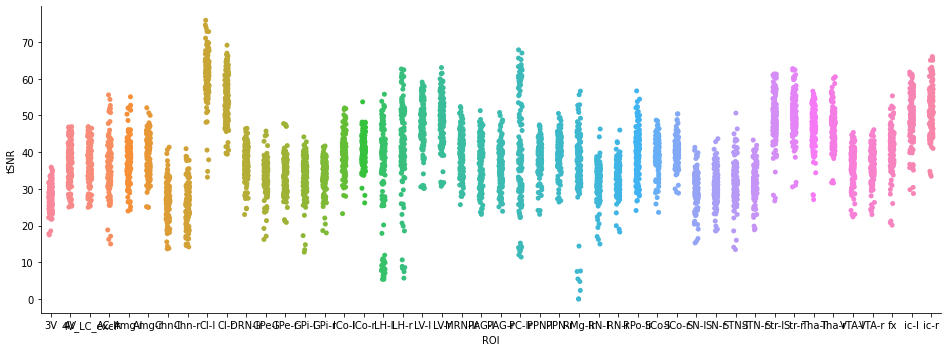

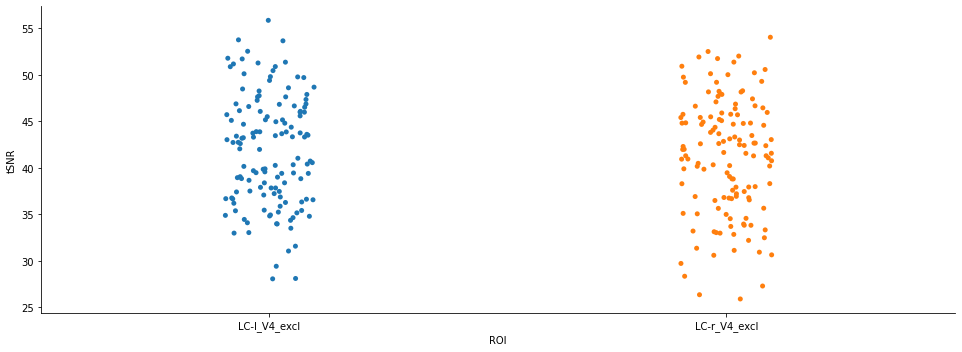

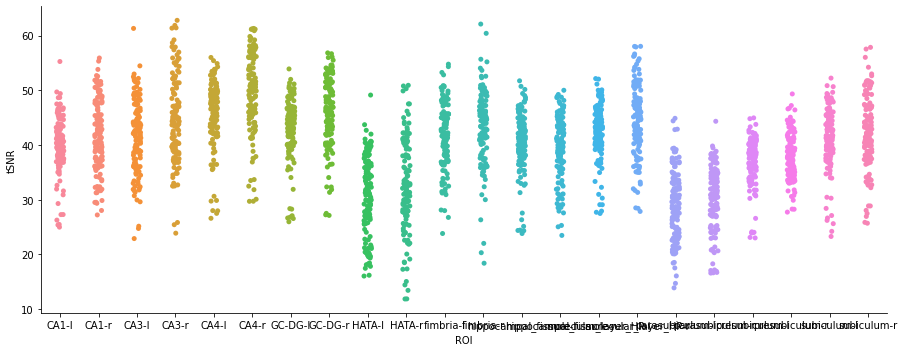

In [18]:
## mrlc-task: tSNR estimates, make table
for atlas_name in ['MASSP27', 'LC', 'hippSubfield']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-*_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    #all_tsnr_table.to_csv(f'../derivatives/tsnr/all_tsnrs_{atlas_name}_table.tsv', sep='\t')
#    all_tsnr_table

    fg = sns.catplot(x='ROI', y='tSNR', data=all_tsnr_table.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'))
    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'../figures/tsnr-{atlas_name}.pdf', bbox_inches='tight')

    display(all_tsnr_table)


In [91]:
# collapse across hemis
def collapse_hemis(data):
    data.columns = data.columns.str.replace('_V4_excl', '')
    data.columns = data.columns.str.replace('GC-', '')
    data.columns = data.columns.str.replace('Chn', 'BF')
    
    for col in data.columns:
        if col.endswith('-l'):
            matching_col = col.replace('-l', '-r')
            if matching_col in data.columns:
                new_col_name = col[:-2]  # Remove the suffix '-l'
                data[new_col_name] = (data[col] + data[matching_col]) / 2
                # Drop the original columns
                data.drop(columns=[col, matching_col], inplace=True)

    data.columns = [col.replace('-lr', '') for col in data.columns]
    return data



# Initialize an empty DataFrame to store the aggregated results
aggregated_results = pd.DataFrame()

# Function to remove -l and -r from ROI names
def normalize_roi(roi):
    if roi.endswith('-l') or roi.endswith('-r'):
        return roi[:-2]
    return roi


all_tSNRs = pd.DataFrame()
# Loop through each atlas
for atlas_name in ['MASSP27', 'LC', 'hippSubfield']:
    # Load and concatenate all TSV files for the current atlas
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-*_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn])

    all_tsnr_table = all_tsnr_table.reset_index()
    all_tsnr_table.drop(['session', 'task'], axis=1, inplace=True)
    averaged_df = all_tsnr_table.mean().to_frame().transpose()
    averaged_df.drop(['subject', 'run'], axis=1, inplace=True)
    averaged_df = averaged_df.reset_index()
    averaged_df_fin = collapse_hemis(averaged_df)

    if atlas_name == 'MASSP27':
        #select only certain columns
        ROIs = ['VTA', 'SN', 'BF', 'Str', 'DRN', 'MRN']
        averaged_df_fin = averaged_df_fin[ROIs]
        
    if atlas_name == 'hippSubfield':
        #select only certain columns
        ROIs = ['CA1', 'CA3', 'DG']
        averaged_df_fin = averaged_df_fin[ROIs]
        
    if atlas_name == 'LC':
        ROIs= ['LC']
        averaged_df_fin = averaged_df_fin[ROIs]
        
    averaged_df_fin = pd.DataFrame(averaged_df_fin)
    all_tSNRs = pd.concat([all_tSNRs, averaged_df_fin], axis = 1)
  
all_tSNRs.to_csv(f'beth/stats/tSNR/average_tSNR_per_ROI.tsv', sep='\t')

# extract reversal learning data only

3V         4V      Amg-l      Amg-r  \
subject session task run                                               
2       rbrevl  revl 1    33.656030  46.460456  40.941743  42.113533   
                     2    30.328905  46.488560  35.569414  32.759006   
3       rbrevl  revl 1    29.972088  44.180909  44.048273  40.645398   
                     2    29.828587  43.976950  43.682196  39.047739   
4       rbrevl  revl 1    22.715034  31.316185  34.393683  31.146433   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    22.867503  41.020339  38.236388  38.384931   
43      rbrevl  revl 1    24.390589  28.489964  37.816991  44.736738   
                     2    24.709187  29.586957  35.947621  42.621433   
44      rbrevl  revl 1    26.172646  34.638818  27.664703  29.041362   
                     2    26.258178  34.598339  28.005644  28.847553   

                               Cl-l       Cl-r      GPe-l      GPe-r  \
subject session task run                                               
2       rbrevl  revl 1    66.970784  72.867140  39.178655  37.920544   
                     2    67.414533  70.263869  36.256367  37.066164   
3       rbrevl  revl 1    64.463873  61.345038  39.051972  36.830239   
                     2    65.084723  57.822083  37.831681  37.073546   
4       rbrevl  revl 1    48.769895  43.988321  29.675653  30.292056   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    63.067079  55.829649  33.516415  32.079674   
43      rbrevl  revl 1    61.494481  54.640358  34.097486  33.487504   
                     2    58.450852  52.124928  35.123486  33.464621   
44      rbrevl  revl 1    55.624287  55.881197  21.197376  26.340121   
                     2    56.035449  56.037007  21.434452  26.081482   

                              GPi-l      GPi-r  ...      STN-r      Str-l  \
subject session task run                        ...                         
2       rbrevl  revl 1    41.289543  37.908695  ...  32.136408  56.770423   
                     2    37.165465  32.666809  ...  29.050740  55.052385   
3       rbrevl  revl 1    41.273090  36.979453  ...  34.700800  55.263951   
                     2    38.512210  35.883382  ...  34.804861  55.080109   
4       rbrevl  revl 1    26.657425  27.406135  ...  27.305317  43.142261   
...                             ...        ...  ...        ...        ...   
42      rbrevl  revl 2    34.255548  32.028424  ...  29.165267  50.421705   
43      rbrevl  revl 1    32.927087  33.739032  ...  32.091722  49.305278   
                     2    32.948629  32.840266  ...  34.304020  50.218373   
44      rbrevl  revl 1    20.970473  28.826844  ...  32.511682  46.422677   
                     2    18.709212  27.049251  ...  31.829852  47.674745   

                              Str-r      Tha-l      Tha-r      VTA-l  \
subject session task run                                               
2       rbrevl  revl 1    57.270517  56.413076  57.762462  37.063787   
                     2    54.984268  54.479054  55.888436  35.343742   
3       rbrevl  revl 1    54.930409  52.888789  51.166934  40.166721   
                     2    53.967200  51.251382  50.484067  38.321837   
4       rbrevl  revl 1    44.328135  40.085841  42.629008  31.920638   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    49.179419  47.121146  47.386501  36.385721   
43      rbrevl  revl 1    50.483176  47.822421  46.090752  33.477553   
                     2    50.026329  47.277638  45.702598  36.811282   
44      rbrevl  revl 1    51.624038  50.829740  52.520145  34.884889   
                     2    52.000871  50.441419  52.924977  32.269622   

                              VTA-r         fx       ic-l       ic-r  
subject session task run                                              
2       rbrevl  revl 1    36.531661  50.379901  59.451128  61.655016  
       

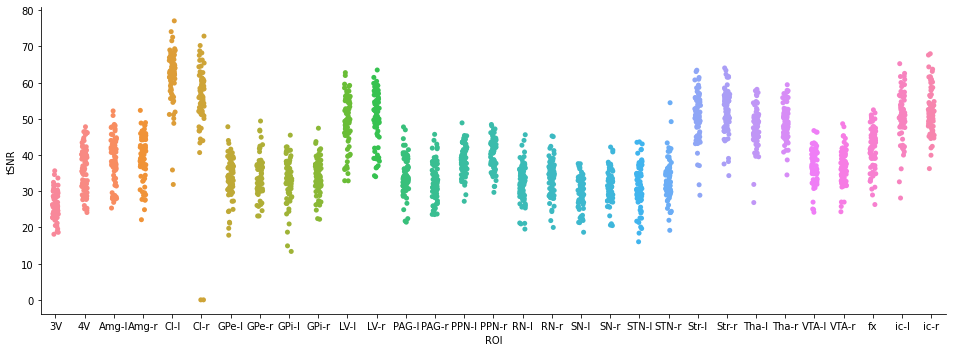

In [3]:
## All tSNR estimates found
for atlas_name in ['MASSP']:# ['WM-rep']:#['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-revl_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table
    all_tsnr_table.to_csv(f'../derivatives/tsnr/revl_tsnrs_{atlas_name}_table.tsv', sep='\t')
#    all_tsnr_table

    fg = sns.catplot(x='ROI', y='tSNR', data=all_tsnr_table.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'))
    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'../figures/tsnr-revl-{atlas_name}.pdf', bbox_inches='tight')

    display(all_tsnr_table)

In [6]:
col_order = ['dlPFC-l', 'dlPFC-r', 'mPFC-l',
       'mPFC-r', 'PPC-l', 'PPC-r',
             'Tha-l', 'Tha-r',
             'Ca-l', 'Ca-r','Pu-l', 'Pu-r',  'NAC-l', 'NAC-r',
            'GPe-l', 'GPe-r', 'GPi-l', 'GPi-r',
             'STN-l', 'STN-r', 
              'PAG-l', 'PAG-r','PPN-l', 'PPN-r', 'RN-l', 'RN-r', 
             'SN-l', 'SN-r',
           'SNc-l', 'SNc-r', 'SNr-l', 'SNr-r',  'PBP-l', 'PBP-r', 
              'VTA-l', 'VTA-r', 'VTAnc-l', 'VTAnc-r' ]

col_order_MB = [ 
              'PAG-l', 'PAG-r','PPN-l', 'PPN-r', 'RN-l', 'RN-r', 
             'SN-l', 'SN-r',
           'SNc-l', 'SNc-r', 'SNr-l', 'SNr-r',  'PBP-l', 'PBP-r', 
              'VTA-l', 'VTA-r', 'VTAnc-l', 'VTAnc-r' ]

col_order_BG = ['Str-l', 'Str-r',
             'Ca-l', 'Ca-r','Pu-l', 'Pu-r',  'NAC-l', 'NAC-r',
            'GPe-l', 'GPe-r', 'GPi-l', 'GPi-r','STN-l', 'STN-r'

               ]

Str-l      Str-r       Ca-l       Ca-r  \
subject session task run                                               
2       rbrevl  revl 1    56.770423  57.270517  58.536227  61.909484   
                     2    55.052385  54.984268  56.794813  58.903839   
3       rbrevl  revl 1    55.263951  54.930409  56.609866  57.610071   
                     2    55.080109  53.967200  56.335821  56.903042   
4       rbrevl  revl 1    43.142261  44.328135  42.200773  46.830551   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    50.421705  49.179419  51.184376  52.520897   
43      rbrevl  revl 1    49.305278  50.483176  48.792729  53.275908   
                     2    50.218373  50.026329  51.225525  53.471387   
44      rbrevl  revl 1    46.422677  51.624038  47.858623  54.720979   
                     2    47.674745  52.000871  49.023088  54.797786   

                               Pu-l       Pu-r      NAC-l      NAC-r  \
subject session task run                                               
2       rbrevl  revl 1    55.337955  53.098211  28.381855  35.631349   
                     2    54.339095  51.617962  26.087942  27.482924   
3       rbrevl  revl 1    56.022336  54.126453  51.199064  56.235021   
                     2    55.507738  53.124333  55.699201  54.421477   
4       rbrevl  revl 1    43.811860  42.601807  41.270926  39.735569   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    50.365489  48.324381  40.863960  44.281150   
43      rbrevl  revl 1    50.713395  49.121599  40.766967  41.157713   
                     2    49.975727  48.231148  41.353076  44.586980   
44      rbrevl  revl 1    46.481024  50.793417  35.444689  48.901406   
                     2    47.675566  51.037485  36.372357  51.150516   

                              GPe-l      GPe-r      GPi-l      GPi-r  \
subject session task run                                               
2       rbrevl  revl 1    39.178655  37.920544  41.289543  37.908695   
                     2    36.256367  37.066164  37.165465  32.666809   
3       rbrevl  revl 1    39.051972  36.830239  41.273090  36.979453   
                     2    37.831681  37.073546  38.512210  35.883382   
4       rbrevl  revl 1    29.675653  30.292056  26.657425  27.406135   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    33.516415  32.079674  34.255548  32.028424   
43      rbrevl  revl 1    34.097486  33.487504  32.927087  33.739032   
                     2    35.123486  33.464621  32.948629  32.840266   
44      rbrevl  revl 1    21.197376  26.340121  20.970473  28.826844   
                     2    21.434452  26.081482  18.709212  27.049251   

                              STN-l      STN-r  
subject session task run                        
2       rbrevl  revl 1    34.848609  32.136408  
                     2    32.876949  29.050740  
3       rbrevl  revl 1    37.918330  34.700800  
                     2    34.261426  34.804861  
4       rbrevl  revl 1    19.702090  27.305317  
...                             ...        ...  
42      rbrevl  revl 2    27.507059  29.165267  
43      rbrevl  revl 1    33.931272  32.091722  
                     2    34.825656  34.304020  
44      rbrevl  revl 1    22.597543  32.511682  
                     2    22.556729  31.829852  

[70 rows x 14 columns]

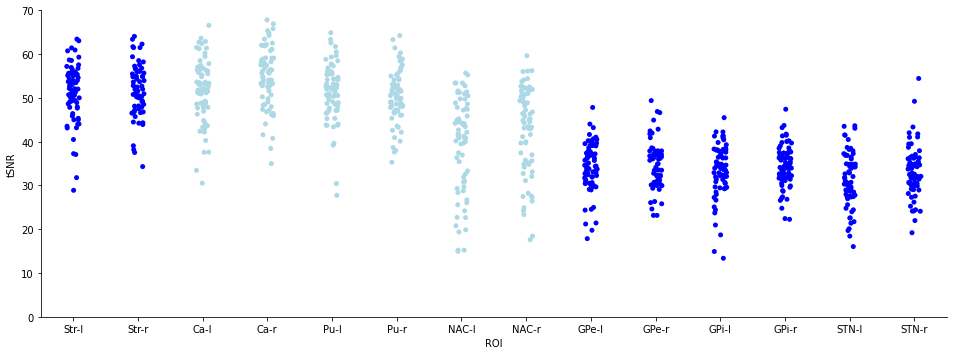

In [57]:
## All tSNR estimates found
for atlas_name in ['MASSP']:# ['WM-rep']:#['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-revl_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    MASSPstr_tsnr_table=all_tsnr_table[['Str-l', 'Str-r']]
#     all_tsnr_table.to_csv(f'../derivatives/tsnr/revl_tsnrs_{atlas_name}_table.tsv', sep='\t')
# #    all_tsnr_table
for atlas_name in ['WM-rep']:#['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-revl_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table = all_tsnr_table.merge(MASSPstr_tsnr_table, on=['subject', 'session', 'task', 'run'])
    df_excluded = all_tsnr_table.drop(['BA24-l', 'BA24-r', 'BA32-l', 'BA32-r', 'BA40-l', 'BA40-r', 'BA46-l',
           'BA46-r', 'BA7-l', 'BA7-r', 'BA74-l', 'BA74-r', 'BA8-l', 'BA8-r','BA9-l', 'BA9-r', 
             'PAG-l', 'PAG-r','PPN-l', 'PPN-r', 'RN-l', 'RN-r', 
             'SN-l', 'SN-r',
           'SNc-l', 'SNc-r', 'SNr-l', 'SNr-r',  'PBP-l', 'PBP-r', 
              'VTA-l', 'VTA-r', 'VTAnc-l', 'VTAnc-r' ], axis=1)
    new_df = df_excluded[col_order_BG]
    new_df
    ['Str-l', 'Str-r',
             'Ca-l', 'Ca-r','Pu-l', 'Pu-r',  'NAC-l', 'NAC-r',
            'GPe-l', 'GPe-r', 'GPi-l', 'GPi-r','STN-l', 'STN-r'

               ]
    roi_colors = {'Str-l': 'blue', 'Str-r': 'blue', 'Ca-l': 'lightblue', 'Ca-r': 'lightblue',
                  'Pu-l': 'lightblue', 'Pu-r': 'lightblue',  'NAC-l': 'lightblue', 'NAC-r': 'lightblue',
            'GPe-l': 'blue', 'GPe-r': 'blue', 'GPi-l': 'blue', 'GPi-r': 'blue',
                  'STN-l': 'blue', 'STN-r': 'blue'}


    fg = sns.catplot(x='ROI', y='tSNR', data=new_df.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'),
                    palette=roi_colors)
    fg.set(ylim=(0, 70))
    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'../figures/tsnr-revl-{atlas_name}-BasalGangliaROIs.pdf', bbox_inches='tight')

    display(new_df)
    
#     display(all_tsnr_table)

/tmp/ipykernel_97009/2961444578.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg = sns.boxplot(x='ROI', y='tSNR', data=new_df.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'),


Str-l      Str-r       Ca-l       Ca-r  \
subject session task run                                               
2       rbrevl  revl 1    56.770423  57.270517  58.536227  61.909484   
                     2    55.052385  54.984268  56.794813  58.903839   
3       rbrevl  revl 1    55.263951  54.930409  56.609866  57.610071   
                     2    55.080109  53.967200  56.335821  56.903042   
4       rbrevl  revl 1    43.142261  44.328135  42.200773  46.830551   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    50.421705  49.179419  51.184376  52.520897   
43      rbrevl  revl 1    49.305278  50.483176  48.792729  53.275908   
                     2    50.218373  50.026329  51.225525  53.471387   
44      rbrevl  revl 1    46.422677  51.624038  47.858623  54.720979   
                     2    47.674745  52.000871  49.023088  54.797786   

                               Pu-l       Pu-r      NAC-l      NAC-r  \
subject session task run                                               
2       rbrevl  revl 1    55.337955  53.098211  28.381855  35.631349   
                     2    54.339095  51.617962  26.087942  27.482924   
3       rbrevl  revl 1    56.022336  54.126453  51.199064  56.235021   
                     2    55.507738  53.124333  55.699201  54.421477   
4       rbrevl  revl 1    43.811860  42.601807  41.270926  39.735569   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    50.365489  48.324381  40.863960  44.281150   
43      rbrevl  revl 1    50.713395  49.121599  40.766967  41.157713   
                     2    49.975727  48.231148  41.353076  44.586980   
44      rbrevl  revl 1    46.481024  50.793417  35.444689  48.901406   
                     2    47.675566  51.037485  36.372357  51.150516   

                              GPe-l      GPe-r      GPi-l      GPi-r  \
subject session task run                                               
2       rbrevl  revl 1    39.178655  37.920544  41.289543  37.908695   
                     2    36.256367  37.066164  37.165465  32.666809   
3       rbrevl  revl 1    39.051972  36.830239  41.273090  36.979453   
                     2    37.831681  37.073546  38.512210  35.883382   
4       rbrevl  revl 1    29.675653  30.292056  26.657425  27.406135   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    33.516415  32.079674  34.255548  32.028424   
43      rbrevl  revl 1    34.097486  33.487504  32.927087  33.739032   
                     2    35.123486  33.464621  32.948629  32.840266   
44      rbrevl  revl 1    21.197376  26.340121  20.970473  28.826844   
                     2    21.434452  26.081482  18.709212  27.049251   

                              STN-l      STN-r  
subject session task run                        
2       rbrevl  revl 1    34.848609  32.136408  
                     2    32.876949  29.050740  
3       rbrevl  revl 1    37.918330  34.700800  
                     2    34.261426  34.804861  
4       rbrevl  revl 1    19.702090  27.305317  
...                             ...        ...  
42      rbrevl  revl 2    27.507059  29.165267  
43      rbrevl  revl 1    33.931272  32.091722  
                     2    34.825656  34.304020  
44      rbrevl  revl 1    22.597543  32.511682  
                     2    22.556729  31.829852  

[70 rows x 14 columns]

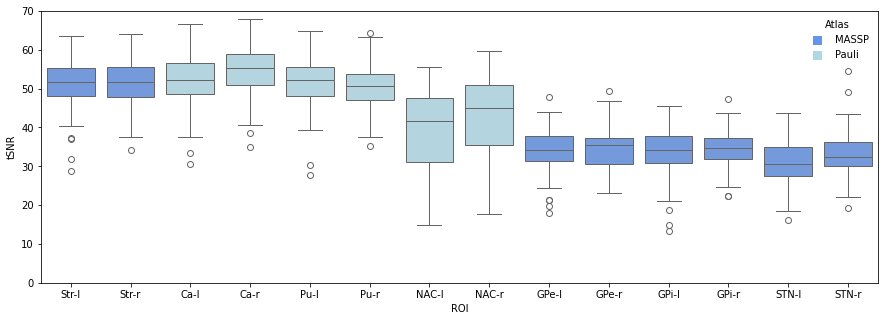

In [32]:
## All tSNR estimates found
for atlas_name in ['MASSP']:# ['WM-rep']:#['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-revl_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    MASSPstr_tsnr_table=all_tsnr_table[['Str-l', 'Str-r']]
#     all_tsnr_table.to_csv(f'../derivatives/tsnr/revl_tsnrs_{atlas_name}_table.tsv', sep='\t')
# #    all_tsnr_table
for atlas_name in ['WM-rep']:#['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-revl_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table = all_tsnr_table.merge(MASSPstr_tsnr_table, on=['subject', 'session', 'task', 'run'])
    df_excluded = all_tsnr_table.drop(['BA24-l', 'BA24-r', 'BA32-l', 'BA32-r', 'BA40-l', 'BA40-r', 'BA46-l',
           'BA46-r', 'BA7-l', 'BA7-r', 'BA74-l', 'BA74-r', 'BA8-l', 'BA8-r','BA9-l', 'BA9-r', 
             'PAG-l', 'PAG-r','PPN-l', 'PPN-r', 'RN-l', 'RN-r', 
             'SN-l', 'SN-r',
           'SNc-l', 'SNc-r', 'SNr-l', 'SNr-r',  'PBP-l', 'PBP-r', 
              'VTA-l', 'VTA-r', 'VTAnc-l', 'VTAnc-r' ], axis=1)
    new_df = df_excluded[col_order_BG]
    new_df
    ['Str-l', 'Str-r',
             'Ca-l', 'Ca-r','Pu-l', 'Pu-r',  'NAC-l', 'NAC-r',
            'GPe-l', 'GPe-r', 'GPi-l', 'GPi-r','STN-l', 'STN-r'

               ]
    roi_colors = {'Str-l': 'cornflowerblue', 'Str-r': 'cornflowerblue', 
                  'Ca-l': 'lightblue', 'Ca-r': 'lightblue',
                  'Pu-l': 'lightblue', 'Pu-r': 'lightblue',  
                  'NAC-l': 'lightblue', 'NAC-r': 'lightblue',
            'GPe-l': 'cornflowerblue', 'GPe-r': 'cornflowerblue',
                  'GPi-l': 'cornflowerblue', 'GPi-r': 'cornflowerblue',
                  'STN-l': 'cornflowerblue', 'STN-r': 'cornflowerblue'}


    fg = sns.boxplot(x='ROI', y='tSNR', data=new_df.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'),
                    palette=roi_colors)
    fg.set(ylim=(0, 70))
    legend_labels = ['MASSP', 'Pauli']  
       
    legend_colors = {'MASSP': 'cornflowerblue', 'Pauli': 'lightblue'}  

    # Create handles for legend entries
    handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10) for color in legend_colors.values()]

    # Map labels to handles in a dictionary
    label_handles = dict(zip(legend_labels, handles))

    # Add legend to the plot
    fg.legend(label_handles.values(), label_handles.keys(), title='Atlas', loc='upper right',frameon=False)

    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'../figures/tsnr-bxplt_revl-{atlas_name}-BasalGangliaROIs.pdf', bbox_inches='tight')

    display(new_df)
    
#     display(all_tsnr_table)

/tmp/ipykernel_97009/1652189776.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg = sns.boxplot(x='ROI', y='tSNR', data=new_df.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'),


PAG-l      PAG-r      PPN-l      PPN-r  \
subject session task run                                               
2       rbrevl  revl 1    41.484527  41.919117  44.675017  44.701244   
                     2    38.982565  42.173579  41.842040  44.471606   
3       rbrevl  revl 1    39.620926  39.320372  43.715219  42.095699   
                     2    40.643654  37.467746  43.538384  40.839988   
4       rbrevl  revl 1    36.947959  24.611800  35.927431  37.685432   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    32.596365  37.602979  41.153110  41.077746   
43      rbrevl  revl 1    33.097543  23.719190  38.030521  39.446588   
                     2    34.010952  23.616354  39.237543  38.756050   
44      rbrevl  revl 1    38.242877  31.003215  37.705508  43.015133   
                     2    36.837299  32.171335  38.164130  41.805108   

                               RN-l       RN-r       SN-l       SN-r  \
subject session task run                                               
2       rbrevl  revl 1    31.435662  31.928339  29.102593  27.342736   
                     2    28.853460  29.379837  26.385409  25.594629   
3       rbrevl  revl 1    31.803898  32.823436  29.996484  31.280108   
                     2    29.455887  30.576040  27.103834  29.829619   
4       rbrevl  revl 1    25.976169  28.236002  27.292243  28.118890   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    30.689210  34.165423  27.076350  28.987875   
43      rbrevl  revl 1    32.059492  34.759953  27.978838  28.138924   
                     2    32.676857  35.779469  30.686723  31.228091   
44      rbrevl  revl 1    32.214058  34.224200  23.356903  33.562735   
                     2    31.744379  34.558820  22.354967  31.553482   

                              SNc-l      SNc-r      SNr-l      SNr-r  \
subject session task run                                               
2       rbrevl  revl 1    33.685411  32.390543  28.788176  29.254165   
                     2    29.810290  31.580628  25.112001  26.339576   
3       rbrevl  revl 1    34.869849  35.637144  29.447055  31.578051   
                     2    30.493505  32.887403  26.964250  30.569292   
4       rbrevl  revl 1    31.169258  31.261922  25.719755  27.553013   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    28.827497  29.606530  25.414645  26.606387   
43      rbrevl  revl 1    32.119725  31.897626  26.852982  26.278632   
                     2    35.340003  34.819525  29.102879  28.850318   
44      rbrevl  revl 1    27.162838  35.918186  21.901857  33.096417   
                     2    23.606551  33.441760  20.943237  31.599658   

                              PBP-l      PBP-r      VTA-l      VTA-r  \
subject session task run                                               
2       rbrevl  revl 1    35.853400  35.020305  37.063787  36.531661   
                     2    33.773375  33.607015  35.343742  35.534375   
3       rbrevl  revl 1    39.869937  40.790508  40.166721  39.931757   
                     2    36.949198  38.173932  38.321837  38.059219   
4       rbrevl  revl 1    31.041639  30.757131  31.920638  32.822835   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    33.066652  35.137025  36.385721  36.607574   
43      rbrevl  revl 1    33.670017  37.004241  33.477553  35.554256   
                     2    35.074346  38.692520  36.811282  37.550954   
44      rbrevl  revl 1    31.629582  37.686916  34.884889  36.868623   
                     2    29.771209  37.057094  32.269622  34.748961   

                            VTAnc-l    VTAnc-r  
subject session task run                        
2       rbrevl  revl 1    36.636823  31.873455  
                     2    33.408178  35.053271  
3       rbrevl  revl 1    43.907429  40.368967  
                     2    34.989483  

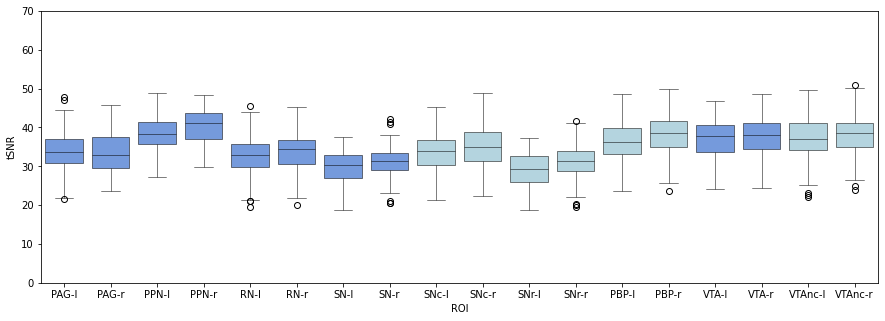

In [33]:
## Only specific tSNR estimates 
for atlas_name in ['WM-rep']:#['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-revl_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table.to_csv(f'../derivatives/tsnr/revl_tsnrs_{atlas_name}_midbrain_table.tsv', sep='\t')
#    all_tsnr_table
    df_excluded = all_tsnr_table.drop(['BA24-l', 'BA24-r', 'BA32-l', 'BA32-r', 'BA40-l', 'BA40-r', 'BA46-l',
           'BA46-r', 'BA7-l', 'BA7-r', 'BA74-l', 'BA74-r', 'BA8-l', 'BA8-r','BA9-l', 'BA9-r', 'Ca-l',
             'Ca-r',
             'GPe-l',
             'GPe-r',
             'GPi-l',
             'GPi-r',
             'NAC-l',
             'NAC-r','Pu-l',
             'Pu-r','STN-l',
             'STN-r',
             'Tha-l',
             'Tha-r',
             'dlPFC-l',
             'dlPFC-r',
             'mPFC-l',
             'mPFC-r','PPC-l',
             'PPC-r'], axis=1)
    new_df = df_excluded[col_order_MB]
    new_df
    roi_colors = {'PAG-l': 'cornflowerblue', 'PAG-r': 'cornflowerblue', 
                  'RN-l': 'cornflowerblue', 'RN-r': 'cornflowerblue',
                  'SNc-l': 'lightblue', 'SNc-r': 'lightblue',
                  'SNr-l': 'lightblue', 'SNr-r': 'lightblue',  
                  'VTAnc-l': 'lightblue', 'VTAnc-r': 'lightblue',
                  'PBP-l': 'lightblue', 'PBP-r': 'lightblue',
                    'PPN-l': 'cornflowerblue', 'PPN-r': 'cornflowerblue',
                  'SN-l': 'cornflowerblue', 'SN-r': 'cornflowerblue',
                      'VTA-l': 'cornflowerblue', 'VTA-r': 'cornflowerblue'}


    fg = sns.boxplot(x='ROI', y='tSNR', data=new_df.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'),
                    linewidth =.5, fill = True, linecolor= 'black', palette=roi_colors)
#     fg.add_legend(title='atlas', labels=['MASSP', 'Pauli']),#label_color=['blue', 'red'])
#     legend_colors = {'MASSP': 'cornflowerblue', 'Pauli': 'lightblue'}  # Specify colors for each label

#     fg.legend(legend_labels, title='Legend Title', labels=legend_colors)


    fg.set(ylim=(0, 70))

    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'../figures/tsnr-bxplt_revl-{atlas_name}-midbrainROIs.pdf', bbox_inches='tight')

    display(new_df)

3V         4V      Amg-l      Amg-r  \
subject session task run                                               
2       rbrevl  revl 1    33.656030  46.460456  40.941743  42.113533   
                     2    30.328905  46.488560  35.569414  32.759006   
3       rbrevl  revl 1    29.972088  44.180909  44.048273  40.645398   
                     2    29.828587  43.976950  43.682196  39.047739   
4       rbrevl  revl 1    22.715034  31.316185  34.393683  31.146433   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    22.867503  41.020339  38.236388  38.384931   
43      rbrevl  revl 1    24.390589  28.489964  37.816991  44.736738   
                     2    24.709187  29.586957  35.947621  42.621433   
44      rbrevl  revl 1    26.172646  34.638818  27.664703  29.041362   
                     2    26.258178  34.598339  28.005644  28.847553   

                               Cl-l       Cl-r      GPe-l      GPe-r  \
subject session task run                                               
2       rbrevl  revl 1    66.970784  72.867140  39.178655  37.920544   
                     2    67.414533  70.263869  36.256367  37.066164   
3       rbrevl  revl 1    64.463873  61.345038  39.051972  36.830239   
                     2    65.084723  57.822083  37.831681  37.073546   
4       rbrevl  revl 1    48.769895  43.988321  29.675653  30.292056   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    63.067079  55.829649  33.516415  32.079674   
43      rbrevl  revl 1    61.494481  54.640358  34.097486  33.487504   
                     2    58.450852  52.124928  35.123486  33.464621   
44      rbrevl  revl 1    55.624287  55.881197  21.197376  26.340121   
                     2    56.035449  56.037007  21.434452  26.081482   

                              GPi-l      GPi-r  ...      STN-r      Str-l  \
subject session task run                        ...                         
2       rbrevl  revl 1    41.289543  37.908695  ...  32.136408  56.770423   
                     2    37.165465  32.666809  ...  29.050740  55.052385   
3       rbrevl  revl 1    41.273090  36.979453  ...  34.700800  55.263951   
                     2    38.512210  35.883382  ...  34.804861  55.080109   
4       rbrevl  revl 1    26.657425  27.406135  ...  27.305317  43.142261   
...                             ...        ...  ...        ...        ...   
42      rbrevl  revl 2    34.255548  32.028424  ...  29.165267  50.421705   
43      rbrevl  revl 1    32.927087  33.739032  ...  32.091722  49.305278   
                     2    32.948629  32.840266  ...  34.304020  50.218373   
44      rbrevl  revl 1    20.970473  28.826844  ...  32.511682  46.422677   
                     2    18.709212  27.049251  ...  31.829852  47.674745   

                              Str-r      Tha-l      Tha-r      VTA-l  \
subject session task run                                               
2       rbrevl  revl 1    57.270517  56.413076  57.762462  37.063787   
                     2    54.984268  54.479054  55.888436  35.343742   
3       rbrevl  revl 1    54.930409  52.888789  51.166934  40.166721   
                     2    53.967200  51.251382  50.484067  38.321837   
4       rbrevl  revl 1    44.328135  40.085841  42.629008  31.920638   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    49.179419  47.121146  47.386501  36.385721   
43      rbrevl  revl 1    50.483176  47.822421  46.090752  33.477553   
                     2    50.026329  47.277638  45.702598  36.811282   
44      rbrevl  revl 1    51.624038  50.829740  52.520145  34.884889   
                     2    52.000871  50.441419  52.924977  32.269622   

                              VTA-r         fx       ic-l       ic-r  
subject session task run                                              
2       rbrevl  revl 1    36.531661  50.379901  59.451128  61.655016  
       

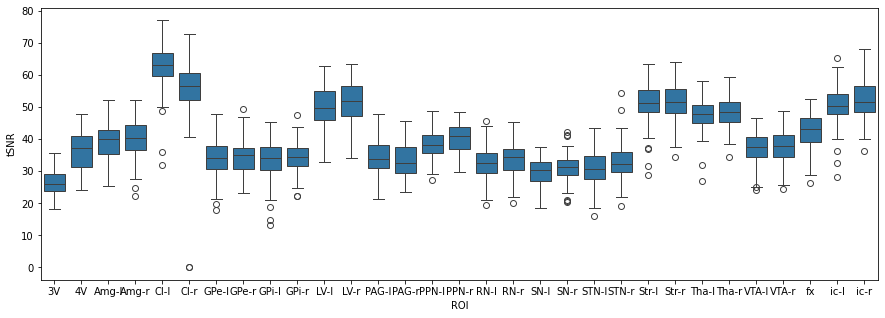

In [17]:
## All tSNR estimates found
for atlas_name in ['MASSP']:# ['WM-rep']:#['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-revl_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table
#     all_tsnr_table.to_csv(f'../derivatives/tsnr/revl_tsnrs_{atlas_name}_table.tsv', sep='\t')
#    all_tsnr_table

    fg = sns.boxplot(x='ROI', y='tSNR', data=all_tsnr_table.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'))
    plt.gcf().set_size_inches(15,5)
#     plt.gcf().savefig(f'../figures/tsnr-revl-{atlas_name}.pdf', bbox_inches='tight')

    display(all_tsnr_table)

In [35]:
# df_excluded = all_tsnr_table.drop(['BA24-l', 'BA24-r', 'BA32-l', 'BA32-r', 'BA40-l', 'BA40-r', 'BA46-l',
#        'BA46-r', 'BA7-l', 'BA7-r', 'BA74-l', 'BA74-r', 'BA8-l', 'BA8-r','BA9-l', 'BA9-r'], axis=1)
# new_df = df_excluded[col_order]
# new_df
list(all_tsnr_table.columns)

['BA24-l',
 'BA24-r',
 'BA32-l',
 'BA32-r',
 'BA40-l',
 'BA40-r',
 'BA46-l',
 'BA46-r',
 'BA7-l',
 'BA7-r',
 'BA74-l',
 'BA74-r',
 'BA8-l',
 'BA8-r',
 'BA9-l',
 'BA9-r',
 'Ca-l',
 'Ca-r',
 'GPe-l',
 'GPe-r',
 'GPi-l',
 'GPi-r',
 'NAC-l',
 'NAC-r',
 'PAG-l',
 'PAG-r',
 'PBP-l',
 'PBP-r',
 'PPC-l',
 'PPC-r',
 'PPN-l',
 'PPN-r',
 'Pu-l',
 'Pu-r',
 'RN-l',
 'RN-r',
 'SN-l',
 'SN-r',
 'SNc-l',
 'SNc-r',
 'SNr-l',
 'SNr-r',
 'STN-l',
 'STN-r',
 'Tha-l',
 'Tha-r',
 'VTA-l',
 'VTA-r',
 'VTAnc-l',
 'VTAnc-r',
 'dlPFC-l',
 'dlPFC-r',
 'mPFC-l',
 'mPFC-r',
 'Str-l',
 'Str-l']

PAG-l      PAG-r      PPN-l      PPN-r  \
subject session task run                                               
2       rbrevl  revl 1    41.484527  41.919117  44.675017  44.701244   
                     2    38.982565  42.173579  41.842040  44.471606   
3       rbrevl  revl 1    39.620926  39.320372  43.715219  42.095699   
                     2    40.643654  37.467746  43.538384  40.839988   
4       rbrevl  revl 1    36.947959  24.611800  35.927431  37.685432   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    32.596365  37.602979  41.153110  41.077746   
43      rbrevl  revl 1    33.097543  23.719190  38.030521  39.446588   
                     2    34.010952  23.616354  39.237543  38.756050   
44      rbrevl  revl 1    38.242877  31.003215  37.705508  43.015133   
                     2    36.837299  32.171335  38.164130  41.805108   

                               RN-l       RN-r       SN-l       SN-r  \
subject session task run                                               
2       rbrevl  revl 1    31.435662  31.928339  29.102593  27.342736   
                     2    28.853460  29.379837  26.385409  25.594629   
3       rbrevl  revl 1    31.803898  32.823436  29.996484  31.280108   
                     2    29.455887  30.576040  27.103834  29.829619   
4       rbrevl  revl 1    25.976169  28.236002  27.292243  28.118890   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    30.689210  34.165423  27.076350  28.987875   
43      rbrevl  revl 1    32.059492  34.759953  27.978838  28.138924   
                     2    32.676857  35.779469  30.686723  31.228091   
44      rbrevl  revl 1    32.214058  34.224200  23.356903  33.562735   
                     2    31.744379  34.558820  22.354967  31.553482   

                              SNc-l      SNc-r      SNr-l      SNr-r  \
subject session task run                                               
2       rbrevl  revl 1    33.685411  32.390543  28.788176  29.254165   
                     2    29.810290  31.580628  25.112001  26.339576   
3       rbrevl  revl 1    34.869849  35.637144  29.447055  31.578051   
                     2    30.493505  32.887403  26.964250  30.569292   
4       rbrevl  revl 1    31.169258  31.261922  25.719755  27.553013   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    28.827497  29.606530  25.414645  26.606387   
43      rbrevl  revl 1    32.119725  31.897626  26.852982  26.278632   
                     2    35.340003  34.819525  29.102879  28.850318   
44      rbrevl  revl 1    27.162838  35.918186  21.901857  33.096417   
                     2    23.606551  33.441760  20.943237  31.599658   

                              PBP-l      PBP-r      VTA-l      VTA-r  \
subject session task run                                               
2       rbrevl  revl 1    35.853400  35.020305  37.063787  36.531661   
                     2    33.773375  33.607015  35.343742  35.534375   
3       rbrevl  revl 1    39.869937  40.790508  40.166721  39.931757   
                     2    36.949198  38.173932  38.321837  38.059219   
4       rbrevl  revl 1    31.041639  30.757131  31.920638  32.822835   
...                             ...        ...        ...        ...   
42      rbrevl  revl 2    33.066652  35.137025  36.385721  36.607574   
43      rbrevl  revl 1    33.670017  37.004241  33.477553  35.554256   
                     2    35.074346  38.692520  36.811282  37.550954   
44      rbrevl  revl 1    31.629582  37.686916  34.884889  36.868623   
                     2    29.771209  37.057094  32.269622  34.748961   

                            VTAnc-l    VTAnc-r  
subject session task run                        
2       rbrevl  revl 1    36.636823  31.873455  
                     2    33.408178  35.053271  
3       rbrevl  revl 1    43.907429  40.368967  
                     2    34.989483  

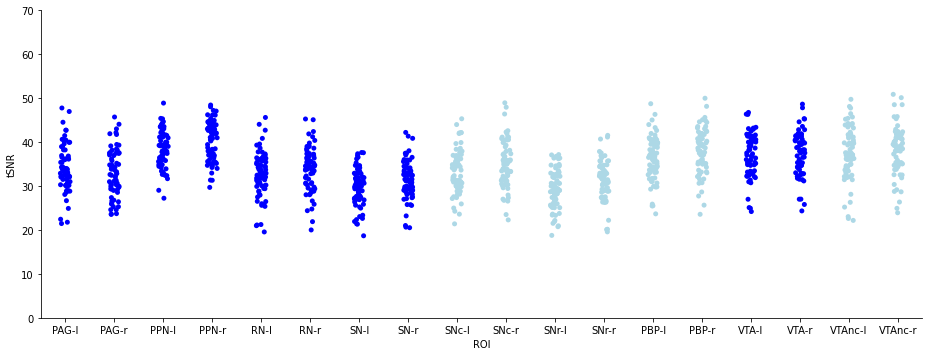

In [58]:
## Only specific tSNR estimates 
for atlas_name in ['WM-rep']:#['MASSP', 'ATAG', 'thalamus']:
    all_tsnr_tables_fn = sorted(glob.glob(f'../derivatives/tsnr/sub-*/ses-*/func/sub-*_ses-*_task-revl_run-*_space-T1w_desc-{atlas_name}-tsnrvalues.tsv'))
    all_tsnr_table = pd.concat([pd.read_csv(x, sep='\t', index_col=['subject', 'session', 'task', 'run']) for x in all_tsnr_tables_fn]) #.set_index(['subject', 'session', 'task', 'run'])
    all_tsnr_table.to_csv(f'../derivatives/tsnr/revl_tsnrs_{atlas_name}_midbrain_table.tsv', sep='\t')
#    all_tsnr_table
    df_excluded = all_tsnr_table.drop(['BA24-l', 'BA24-r', 'BA32-l', 'BA32-r', 'BA40-l', 'BA40-r', 'BA46-l',
           'BA46-r', 'BA7-l', 'BA7-r', 'BA74-l', 'BA74-r', 'BA8-l', 'BA8-r','BA9-l', 'BA9-r', 'Ca-l',
             'Ca-r',
             'GPe-l',
             'GPe-r',
             'GPi-l',
             'GPi-r',
             'NAC-l',
             'NAC-r','Pu-l',
             'Pu-r','STN-l',
             'STN-r',
             'Tha-l',
             'Tha-r',
             'dlPFC-l',
             'dlPFC-r',
             'mPFC-l',
             'mPFC-r','PPC-l',
             'PPC-r'], axis=1)
    new_df = df_excluded[col_order_MB]
    new_df
    roi_colors = {'PAG-l': 'blue', 'PAG-r': 'blue', 
                  'RN-l': 'blue', 'RN-r': 'blue',
                  'SNc-l': 'lightblue', 'SNc-r': 'lightblue',
                  'SNr-l': 'lightblue', 'SNr-r': 'lightblue',  
                  'VTAnc-l': 'lightblue', 'VTAnc-r': 'lightblue',
                  'PBP-l': 'lightblue', 'PBP-r': 'lightblue',
                    'PPN-l': 'blue', 'PPN-r': 'blue', 'SN-l': 'blue', 'SN-r': 'blue',
                      'VTA-l': 'blue', 'VTA-r': 'blue'}


    fg = sns.catplot(x='ROI', y='tSNR', data=new_df.reset_index().melt(id_vars=['subject', 'session', 'task', 'run'], var_name='ROI', value_name='tSNR'),
                    palette=roi_colors)
#     fg.add_legend(title='atlas', labels=['MASSP', 'Pauli'],#label_color=['blue', 'red'])
    fg.set(ylim=(0, 70))

    plt.gcf().set_size_inches(15,5)
    plt.gcf().savefig(f'../figures/tsnr-revl-{atlas_name}-midbrainROIs.pdf', bbox_inches='tight')

    display(new_df)

# 2. RETROICOR estimation
1. Run PhysIO to get RETROICOR, HRV and RVT

unfortunately we need to call matlab for this...

In [3]:
# def find_physLog_file(subject_n, session_n):
!tree /home/Public/trondheim/derivatives/phys_log/sub-057/ses-grids/func/

/home/Public/trondheim/derivatives/phys_log/sub-057/ses-grids/func/
├── sub-057_ses-grids_task-grids_run-1_Info.log
├── sub-057_ses-grids_task-grids_run-1_PULS.log
├── sub-057_ses-grids_task-grids_run-1_RESP.log
├── sub-057_ses-grids_task-grids_run-2_Info.log
├── sub-057_ses-grids_task-grids_run-2_PULS.log
├── sub-057_ses-grids_task-grids_run-2_RESP.log
├── sub-057_ses-grids_task-grids_run-3_Info.log
├── sub-057_ses-grids_task-grids_run-3_PULS.log
└── sub-057_ses-grids_task-grids_run-3_RESP.log

0 directories, 9 files


In [4]:
def prep_matlab_args(subject_n, session_n, task, run, overwrite=0):
    info_file = '/home/Public/trondheim/derivatives/phys_log/sub-{subject_n}/ses-{session_n}/func/sub-{subject_n}_ses-{session_n}_task-{task}_run-{run}_Info.log'.format(**locals())
    puls_file = '/home/Public/trondheim/derivatives/phys_log/sub-{subject_n}/ses-{session_n}/func/sub-{subject_n}_ses-{session_n}_task-{task}_run-{run}_PULS.log'.format(**locals())
    resp_file = '/home/Public/trondheim/derivatives/phys_log/sub-{subject_n}/ses-{session_n}/func/sub-{subject_n}_ses-{session_n}_task-{task}_run-{run}_RESP.log'.format(**locals())
    
    if os.path.isfile(info_file) and os.path.isfile(puls_file) and os.path.isfile(resp_file):
        print(f'Log files for {subject_n} {session_n} {task} {run} exist')
    else:
        print(f'Log files for {subject_n} {session_n} {task} {run} do not exist')
        
    nii = nib.load(info_file.replace('Info.log', 'bold.nii.gz').replace('phys_log', 'bids'))
    n_vols = nii.header['dim'][4]
    n_slices = nii.header['dim'][3]
    t_r = nii.header['pixdim'][4]
    per_slice = 0
    save_dir = os.path.dirname(info_file).replace('phys_log', 'retroicor')
    os.makedirs(save_dir, exist_ok=True)
    
    print(f'saving to {save_dir}')
    
    mlcode = '\"cd(\'/home/Public/trondheim/scripts/matlabshit\'); addpath(\'/home/Public/trondheim/scripts/matlabshit/tapas-master/PhysIO/code\'); run_physIO(\'{puls_file}\', \'{resp_file}\', \'{info_file}\', {n_vols}, {n_slices}, {t_r}, \'{save_dir}\', {per_slice}, {overwrite}); exit\"'.format(**locals())
    return mlcode

In [5]:
def find_all_to_run(return_tuples=False):
    # if you want to run everything...
#    all_phys_files = sorted(glob.glob('../derivatives/bids/sub-*/ses-*/func/*_physio.tsv.gz'))
#    all_phys_files = [x for x in all_phys_files if not 'recording-' in x]
#    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-(?P<run>\d).*_physio.tsv.gz')

    all_phys_files = sorted(glob.glob('../derivatives/phys_log/sub-*/ses-*/func/*_Info.log'))
#     all_phys_files = [x for x in all_phys_files if not 'recording-' in x]
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-(?P<run>\d)_Info.log')
    
    all_phys_files_dict = [regex.match(x).groupdict() for x in all_phys_files]
    all_phys_files_df = pd.DataFrame.from_dict(all_phys_files_dict).sort_values(['sub','ses','task', 'run']).drop_duplicates()
    
    dict_list = all_phys_files_df.to_dict(orient='records')
    if return_tuples:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    all_phys_files = find_all_to_run()
    
    to_run = []
    for dict_ in all_phys_files:
        fp = '../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

In [6]:
to_run = find_which_to_run()
to_run = [x for x in to_run if os.path.exists('/home/Public/trondheim/derivatives/bids/sub-{}/ses-{}/func/sub-{}_ses-{}_task-{}_run-{}_bold.nii.gz'.format(x[0], x[1], x[0],x[1], x[2], x[3]))]

# to_run = find_all_to_run(True)
# to_run = [x for x in to_run if os.path.exists('/home/Public/trondheim/derivatives/bids/sub-{}/ses-{}/func/sub-{}_ses-{}_task-{}_run-{}_bold.nii.gz'.format(x[0], x[1], x[0],x[1], x[2], x[3]))]

to_run = [x for x in to_run if x[1] == 'grids']
print(to_run)

[('057', 'grids', 'grids', '3')]


In [7]:
def mp_func(tuple_):
    subprocess.run(['matlab', '-nodesktop', '-nosplash', '-r ' + prep_matlab_args(*tuple_)])

# multiprocess
with mp.Pool(8) as p:
    p.map(mp_func, to_run)

Log files for 057 grids grids 3 exist
saving to /home/Public/trondheim/derivatives/retroicor/sub-057/ses-grids/func


In [19]:
#a = prep_matlab_args('057', 'grids', 'grids', 3)

In [29]:
## if there's still runs found that could be run, these are probably errors!
find_which_to_run()

[('007', 'sstmsit', 'msit', '1'),
 ('010', 'rlsat', 'rlsat', '2'),
 ('010', 'rlsat', 'rlsat', '3'),
 ('018', 'rbrevl', 'rb', '2'),
 ('018', 'rbrevl', 'revl', '1'),
 ('018', 'rbrevl', 'revl', '2'),
 ('018', 'rlsat', 'rlsat', '3'),
 ('018', 'sstmsit', 'sst', '2'),
 ('019', 'rbrevl', 'revl', '2'),
 ('022', 'anatomical', 'rs', '1'),
 ('022', 'anatomical', 'rs', '2'),
 ('025', 'sstmsit', 'msit', '2'),
 ('025', 'sstmsit', 'sst', '2'),
 ('044', 'anatomical', 'rs', '2'),
 ('044', 'rbrevl', 'rb', '1'),
 ('044', 'rbrevl', 'rb', '2'),
 ('044', 'rbrevl', 'revl', '2'),
 ('044', 'rlsat', 'rlsat', '1'),
 ('044', 'rlsat', 'rlsat', '2'),
 ('044', 'rlsat', 'rlsat', '3'),
 ('045', 'grids', 'symbols', '1'),
 ('045', 'grids', 'symbols', '2'),
 ('045', 'grids', 'symbols', '3'),
 ('046', 'mrlc', 'mt', '1'),
 ('046', 'mrlc', 'mt', '2'),
 ('048', 'symbols', 'rlsat', '1'),
 ('048', 'symbols', 'rlsat', '2'),
 ('048', 'symbols', 'rlsat', '3'),
 ('048', 'symbols', 'symbols', '1'),
 ('048', 'symbols', 'symbols', '2

#### How large is the influence of each component?
2. Fit GLM, get F-tests

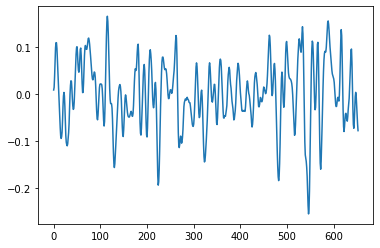

In [96]:
sub = '002'
ses = 'anatomical'
task = 'rs'
run = 1
func_fn = f'../derivatives/high_passed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'
brain_mask = func_fn.replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz').replace('high_passed_func', 'fmriprep/fmriprep')

# load confounds, name columns
confounds = pd.read_csv(f'../derivatives/retroicor_28_regressors/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv', sep='\t', header=None)
confounds = confounds.iloc[:,:28]
confounds

if confounds.shape[-1] > 20:
    hrv_names = ['HRV_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
    rvt_names = ['RVT_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
else:
    hrv_names = ['HRV']
    rvt_names = ['RVT']

confounds.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + hrv_names + rvt_names

plt.plot(confounds['HRV_delay_0s'].values)

In [8]:
from nilearn.glm.first_level.design_matrix import _cosine_drift
from nilearn.plotting import plot_design_matrix

def make_cosine_matrix(func, high_pass=0.01, slice_time_ref=0.5):
    t_r = func.header['pixdim'][4]
    n_scans = func.header['dim'][4]
    start_time = slice_time_ref * t_r
    end_time = (n_scans - 1 + slice_time_ref) * t_r
    frame_times = np.linspace(start_time, end_time, n_scans)
    
    cosines = pd.DataFrame(_cosine_drift(0.01, frame_times))
    cosines.columns = ['cosine_'+str(x) if (x < cosines.shape[1]-1) else 'intercept' for x in cosines.columns]
    return cosines

In [9]:
import pickle as pkl

def fit_physiology_glms(sub, ses, task, run, fwhm=4.5, models=['retroicor', 'cardiac', 'respiratory', 'interaction', 'hrv', 'rvt'], 
                        save_models=False, save_dir='../derivatives/glm_nilearn_retroicor/subject_level_models'):
    func_fn = f'../derivatives/high_passed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'
    brain_mask = func_fn.replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz').replace('high_passed_func', 'fmriprep/fmriprep')

    fwhm_str = str(fwhm).replace('.', 'p')
    
    # load confounds, name columns
    confounds = pd.read_csv(f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv', sep='\t', header=None)
    if confounds.shape[-1] > 25:      # at some point I added delays for the HRV and RVT regressors, but got rid of that again
        confounds = confounds.iloc[:,:28]
    else:
        confounds = confounds.iloc[:,:20]

    if confounds.shape[-1] > 20:
        hrv_names = ['HRV_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
        rvt_names = ['RVT_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
    else:
        hrv_names = ['HRV_delay_0s']
        rvt_names = ['RVT_delay_0s']
    
    confounds.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + hrv_names + rvt_names
    
#     # We're gonna fit 9 GLMs with increasing physiological |model complexity
    if isinstance(models, str):
        models = [models]
    
    for i, model in enumerate(models):
        
        if model == 'retroicor':
            dm = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x]]
            vmax = .80
        elif model == 'cardiac':
            dm = confounds[[x for x in confounds.columns if 'cardiac_' in x and not 'respiratory' in x]]
            vmax = .80
        elif model == 'respiratory':
            dm = confounds[[x for x in confounds.columns if 'respiratory_' in x and not 'cardiac' in x]]
            vmax = .80
        elif model == 'interaction':
            dm = confounds[[x for x in confounds.columns if 'respiratoryxcardiac_' in x]]
            vmax = .5
        elif model == 'hrv':
            dm = confounds[['HRV_delay_0s']]
            vmax = 0.15
        elif model == 'hrv+delays':
            dm = confounds[[x for x in confounds.columns if 'HRV_' in x]]
        elif model == 'rvt':
            vmax = 0.15
            dm = confounds[['RVT_delay_0s']]
        elif model == 'rvt+delays':
            vmax = 0.1
            dm = confounds[[x for x in confounds.columns if 'RVT_' in x]]
        elif model == 'retroicor+hrv':
            vmax = 0.9
            dm = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x or x == 'HRV_delay_0s']]
        elif model == 'retroicor+rvt':
            vmax = 0.9
            dm = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x or x == 'RVT_delay_0s']]
        elif model == 'retroicor+hrv+rvt':
            vmax = 0.9
            dm = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x or x == 'HRV_delay_0s' or x == 'RVT_delay_0s']]
        elif model == 'retroicor+hrv+rvt+delays':
            vmax = 0.9
            dm = confounds
            
        print(dm.shape)
        
        # z-score, make sure all regressors are mean 0 (except intercept)
        dm = dm.apply(lambda x: (x-x.mean())/x.std())

        # add intercept
        dm['intercept'] = 1

        # check for existence of final output file name
        save_fn2 = os.path.join(save_dir, f'sub-{sub}', f'sub-{sub}_ses-{ses}_task-{task}_run-{run}_model-{model}_fwhm-{fwhm_str}_space-T1w_tsnr_pred_ols.nii.gz')
        if os.path.exists(save_fn2):
            continue

        # fit
        flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, smoothing_fwhm=fwhm, noise_model='ols',  # use OLS for tSNR estimations
                              mask_img=brain_mask, n_jobs=10, minimize_memory=False,
                              signal_scaling=False)                                   # don't scale, we need tSNR estimates
        flm_fitted = flm.fit(func_fn, design_matrices=dm)

        # Get the following statistics: R-squared, predicted time series, residuals
        # tSNR: Get residuals for std, get predicted values for mean
        r2_nii = flm_fitted.r_square[0]
        
        residuals_ = flm_fitted.residuals[0]
        predicted_ = flm_fitted.predicted[0]
        
        predicted_mean = nilearn.image.math_img('nii.mean(-1)', nii=predicted_)
        res_std = nilearn.image.math_img('nii.std(-1)', nii=residuals_)
        tsnr_pred = nilearn.image.math_img('nii1/nii2', nii1=predicted_mean, nii2=res_std)
        
        for (spm_name, spm) in zip(['rsquared', 'pred_mean', 'std', 'tsnr_pred'], 
                                    [r2_nii, predicted_mean, res_std, tsnr_pred]):
            save_fn2 = os.path.join(save_dir, f'sub-{sub}', f'sub-{sub}_ses-{ses}_task-{task}_run-{run}_model-{model}_fwhm-{fwhm_str}_space-T1w_{spm_name}_ols.nii.gz')
            dirname = os.path.dirname(save_fn2)
            if not os.path.exists(dirname):
                os.makedirs(dirname)
            spm.to_filename(save_fn2)
            
            # warp
            spm_in_mni_fn = apply_warp(spm, sub=sub)
            save_fn3 = save_fn2.replace('T1w', 'MNI152NLin2009cAsym')
            os.rename(spm_in_mni_fn, save_fn3)

In [10]:
all_subs = [x.split('/')[-2] for x in sorted(glob.glob('../derivatives/retroicor/*/ses-anatomical'))]
all_subs = [x.split('-')[-1] for x in all_subs]
# all_subs

In [ ]:
import itertools
all_combs = list(itertools.product(all_subs, ['anatomical'], ['rs'], [1, 2], [0, 1.5, 6], ['retroicor', 'cardiac', 'respiratory', 'interaction', 'hrv', 'rvt', 'retroicor+hrv+rvt']))
# all_combs

def fit_physiology_glms_catch(sub, ses, task, run, fwhm, model):
    try:
        fit_physiology_glms(sub, ses, task, run, fwhm, model)
    except:
        return '{} {} {} {} {} {} FAILED'.format(sub,ses,task,run,fwhm, model)

Parallel(n_jobs=15, verbose=1)(delayed(fit_physiology_glms_catch)(sub, ses, task, run, fwhm, model) for sub, ses, task, run, fwhm, model in all_combs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  3.8min


### Fit retroicor+HRV+RVT+cosines on non-high-passed data

In [4]:
from nilearn.glm.first_level.design_matrix import _cosine_drift
from nilearn.plotting import plot_design_matrix

def make_cosine_matrix(func, high_pass=0.01, slice_time_ref=0.5):
    t_r = func.header['pixdim'][4]
    n_scans = func.header['dim'][4]
    start_time = slice_time_ref * t_r
    end_time = (n_scans - 1 + slice_time_ref) * t_r
    frame_times = np.linspace(start_time, end_time, n_scans)
    
    cosines = pd.DataFrame(_cosine_drift(0.01, frame_times))
    cosines.columns = ['cosine_'+str(x) if (x < cosines.shape[1]-1) else 'intercept' for x in cosines.columns]
    return cosines

In [12]:
import pickle as pkl

def fit_physiology_glms_cosines(sub, ses, task, run, fwhm=4.5):
    func_fn = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'
    brain_mask = func_fn.replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz')#.replace('high_passed_func', 'fmriprep/fmriprep')

    fwhm_str = str(fwhm).replace('.', 'p')
    
    # load confounds, name columns
    confounds_fn = f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-retroicor_regressors.tsv'
    # check fn
    if not os.path.exists(confounds_fn):
        return 0
    
    confounds = pd.read_csv(confounds_fn, sep='\t', header=None)
    if confounds.shape[-1] > 25:      # at some point I added delays for the HRV and RVT regressors, but got rid of that again
        confounds = confounds.iloc[:,:28]
    else:
        confounds = confounds.iloc[:,:20]

    if confounds.shape[-1] > 20:
        hrv_names = ['HRV_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
        rvt_names = ['RVT_delay_' + str(x) + 's' for x in np.arange(0,21,5)]
    else:
        hrv_names = ['HRV_delay_0s']
        rvt_names = ['RVT_delay_0s']
    
    confounds.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + hrv_names + rvt_names
    confounds = confounds[[x for x in confounds.columns if 'cardiac' in x or 'respiratory' in x or x == 'HRV_delay_0s' or x == 'RVT_delay_0s']]
    
    # add cosines
    confounds = pd.concat([confounds, make_cosine_matrix(nib.load(func_fn))], axis=1)
    
    # check for existence of final output file name
    model = 'retroicor+hrv+rvt+cosines'
    save_fn2 = f'../derivatives/glm_nilearn_retroicor/subject_level_models3/sub-{sub}_ses-{ses}_task-{task}_run-{run}_model-{model}_fwhm-{fwhm_str}_space-T1w_tsnr_pred_ols.nii.gz'
    if os.path.exists(save_fn2):
        return 0

    # fit
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, smoothing_fwhm=fwhm, noise_model='ols',  # use OLS for tSNR estimations
                          mask_img=brain_mask, n_jobs=1, minimize_memory=False,
                          signal_scaling=False)                                   # don't scale, we need tSNR estimates
    flm_fitted = flm.fit(func_fn, design_matrices=confounds)

    # Get the following statistics: R-squared, predicted time series, residuals
    # tSNR: Get residuals for std, get predicted values for mean
    r2_nii = flm_fitted.r_square[0]

    residuals_ = flm_fitted.residuals[0]
    predicted_ = flm_fitted.predicted[0]

    predicted_mean = nilearn.image.math_img('nii.mean(-1)', nii=predicted_)
    res_std = nilearn.image.math_img('nii.std(-1)', nii=residuals_)
    tsnr_pred = nilearn.image.math_img('nii1/nii2', nii1=predicted_mean, nii2=res_std)

    for (spm_name, spm) in zip(['rsquared', 'pred_mean', 'std', 'tsnr_pred'], 
                                [r2_nii, predicted_mean, res_std, tsnr_pred]):
        save_fn2 = f'../derivatives/glm_nilearn_retroicor/subject_level_models3/sub-{sub}_ses-{ses}_task-{task}_run-{run}_model-{model}_fwhm-{fwhm_str}_space-T1w_{spm_name}_ols.nii.gz'
        spm.to_filename(save_fn2)

        # warp
        spm_in_mni_fn = apply_warp(spm, sub=sub)
        save_fn3 = save_fn2.replace('T1w', 'MNI152NLin2009cAsym')
        os.rename(spm_in_mni_fn, save_fn3)

In [13]:
all_subs = [x.split('/')[-2] for x in sorted(glob.glob('../derivatives/retroicor/*/ses-anatomical'))]
all_subs = [x.split('-')[-1] for x in all_subs]
# all_subs

In [14]:
import itertools
all_combs = list(itertools.product(all_subs, ['anatomical'], ['rs'], [1, 2], [0]))
# all_combs

def fit_physiology_glms_cosines_catch(sub, ses, task, run, fwhm):
    try:
        fit_physiology_glms_cosines(sub, ses, task, run, fwhm)
    except:
        return '{} {} {} {} {} {} FAILED'.format(sub,ses,task,run,fwhm)

Parallel(n_jobs=15, verbose=1)(delayed(fit_physiology_glms_cosines_catch)(sub, ses, task, run, fwhm) for sub, ses, task, run, fwhm in all_combs)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:    1.1s
[Parallel(n_jobs=15)]: Done  72 out of  72 | elapsed: 10.0min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## old retroicor GLMs

In [157]:
## Fit glm and save to disk
def make_first_level_model_fn(sub, ses, task, smoothing_fwhm=0, model_n='0', space='T1w', save_dir_name='../derivatives/glm_nilearn_retroicor/subject_level_model'):
    smoothing_fwhm = str(smoothing_fwhm).replace('.', 'p')
    return os.path.join(save_dir_name, f'sub-{sub}/ses-{ses}/func/fwhm-{smoothing_fwhm}/sub-{sub}_ses-{ses}_task-{task}_space-{space}_desc-first-level-model.pkl')


def fit_retroicor_glm(sub, ses, task, return_glm=False):
    
    save_fn = make_first_level_model_fn(sub, ses, task, smoothing_fwhm=0, model_n='0', space='T1w', save_dir_name='../derivatives/glm_nilearn_retroicor/subject_level_model') # f'../derivatives/{save_dir_name}/sub-{sub}/ses-{ses}/func/fwhm-{smoothing_fwhm_str}/model-{model_n}/sub-{sub}_ses-{ses}_task-{task}_space-{space}_desc-first-level-model.pkl'

    funcs = []
    dms = []
    func_fns = sorted(glob.glob('../derivatives/high_passed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_space-T1w_desc-preproc_bold.nii.gz'.format(sub=sub, ses=ses, task=task)))
    for run, func_fn in enumerate(func_fns):
        retroicor_fn = func_fn.replace('high_passed_func', 'retroicor').replace('_space-T1w_desc-preproc_bold.nii.gz', '_desc-retroicor_regressors.tsv')

        ## load func
        func = nib.load(func_fn)
        retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
        retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']

#         # add cosines  # nope, let's use the high-passed data so we can get a R^2 estimate for the physiological noise only
#         design_matrix = pd.concat([retroicor, make_cosine_matrix(func)], 1)
        retroicor['intercept'] = 1    
        design_matrix = retroicor
#         plot_design_matrix(design_matrix)
        funcs.append(func)
        dms.append(design_matrix)
    
    brain_mask = func_fns[0].replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz').replace('high_passed_func', 'fmriprep/fmriprep')
    print('Fitting GLM for sub {} ses {} task {} ({} runs)...'.format(sub, ses, task, len(func_fns)), end='')
    
    # NB; minimize_memory=False saves the model per voxel so we can get R2 estimates to plot
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, smoothing_fwhm=1.5, mask_img=brain_mask, n_jobs=10)
    flm_fitted = flm.fit(funcs, design_matrices=dms)
        
    # save
    os.makedirs(os.path.dirname(save_fn), exist_ok=True)
    with open(save_fn, 'wb') as f:
        pkl.dump(flm_fitted, f, protocol=4)  # protocol=4 required due to size of pkl

    return flm_fitted



In [158]:
def find_all_to_run(return_tuple=False):
    # if you want to run everything...
    all_retroicor_regressors = sorted(glob.glob('../derivatives/retroicor/sub-*/ses-*/func/*retroicor_regressors.tsv'))
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_desc-retroicor_regressors.tsv')
    all_retroicor_regressors_dict = [regex.match(x).groupdict() for x in all_retroicor_regressors]
    all_retroicor_regressors_df = pd.DataFrame.from_dict(all_retroicor_regressors_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_retroicor_regressors_df.to_dict(orient='records')
    if return_tuple:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    # ie returns the tuples corresponding to subjects for which fit_retroicor_glm hasn't been run yet
    all_retroicor_regressors = find_all_to_run()
    
    to_run = []
    for dict_ in all_retroicor_regressors:
        fp = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-retroicor_glm_SPMs.pdf'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

# find_which_to_run()

In [159]:
to_run = find_all_to_run(True)
to_run = [(x[0], x[1], x[2]) for x in to_run if x[1] == 'anatomical']
to_run

[('002', 'anatomical', 'rs'),
 ('003', 'anatomical', 'rs'),
 ('004', 'anatomical', 'rs'),
 ('005', 'anatomical', 'rs'),
 ('006', 'anatomical', 'rs'),
 ('007', 'anatomical', 'rs'),
 ('008', 'anatomical', 'rs'),
 ('009', 'anatomical', 'rs'),
 ('010', 'anatomical', 'rs'),
 ('011', 'anatomical', 'rs'),
 ('012', 'anatomical', 'rs'),
 ('013', 'anatomical', 'rs'),
 ('014', 'anatomical', 'rs'),
 ('015', 'anatomical', 'rs'),
 ('016', 'anatomical', 'rs'),
 ('017', 'anatomical', 'rs'),
 ('018', 'anatomical', 'rs'),
 ('019', 'anatomical', 'rs'),
 ('020', 'anatomical', 'rs'),
 ('021', 'anatomical', 'rs'),
 ('023', 'anatomical', 'rs'),
 ('024', 'anatomical', 'rs'),
 ('025', 'anatomical', 'rs'),
 ('026', 'anatomical', 'rs'),
 ('027', 'anatomical', 'rs'),
 ('029', 'anatomical', 'rs')]

In [134]:
fit_retroicor_glm('002', 'anatomical', 'rs')

Fitting GLM for sub 002 ses anatomical task rs (2 runs)...

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
                high_pass=0.01, hrf_model='glover',
                mask_img='../derivatives/fmriprep/fmriprep/sub-002/ses-anatomical/func/sub-002_ses-anatomical_task-rs_run-1_space-T1w_desc-brain_mask.nii.gz',
                memory=Memory(location=None), memory_level=1, min_onset=-24,
                minimize_memory=True, n_jobs=10, noise_model='ar1',
                signal_scaling=True, slice_time_ref=0.5, smoothing_fwhm=1.5,
                standardize=False, subject_label=None, t_r=1.38,
                target_affine=None, target_shape=None, verbose=0)

In [160]:
#to_run = find_all_to_run(True)

# to_run = [('002', 'anatomical', 'rs'),
#  ('003', 'rlsat', 'rlsat'),
#  ('005', 'sstmsit', 'msit'),
#  ('005', 'sstmsit', 'sst'),
# # ('007', 'rlsat', 'rlsat'),
#  ('009', 'anatomical', 'rs'),
#  ('009', 'sstmsit', 'msit'),
#  ('009', 'sstmsit', 'sst'),
#  ('010', 'anatomical', 'rs'),
#  ('011', 'anatomical', 'rs'),
#  ('011', 'rlsat', 'rlsat')]

# print(to_run)

# beware memory load
#Parallel(n_jobs=8, verbose=1)(delayed(fit_retroicor_glm)(sub, ses, task) for sub, ses, task in to_run)

def fit_retroicor_glm_catch(sub,ses,task):
    try:
        fit_retroicor_glm(sub,ses,task)
    except:
        print('{} {} {} FAILED'.format(sub,ses,task))
        return 1

## with catch
Parallel(n_jobs=5, verbose=1)(delayed(fit_retroicor_glm_catch)(sub, ses, task) for sub, ses, task in to_run)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  26 out of  26 | elapsed: 17.1min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 1,
 None,
 None,
 1,
 None,
 1,
 None]

### Compute first-level contrasts, warp to MNI space

In [165]:
def compute_contrasts(comb, contrasts, space='T1w', save_dir_name='../derivatives/glm_nilearn_retroicor/subject_level_model'):
    sub,ses,task = comb
    
    flm_fn = f'../derivatives/glm_nilearn_retroicor/subject_level_model/sub-{sub}/ses-{ses}/func/fwhm-0/sub-{sub}_ses-{ses}_task-{task}_space-T1w_desc-first-level-model.pkl'
    with open(flm_fn, 'rb') as f:
        first_level_model = pkl.load(f)
    
    for contrast_name, contrast in contrasts.items():
        
        # save all stat maps
        stat_maps = first_level_model.compute_contrast(contrast, output_type='all')
        for stat_map_name, stat_map in stat_maps.items():
#             if not stat_map_name in ['z_score', 'effect_size', 'effect_variance']:
#                 continue  # drop p-value and 'stat'
            save_fn = flm_fn.replace('desc-first-level-model.pkl', f'desc-contrast-{contrast_name}_{stat_map_name}.nii.gz')
            stat_map.to_filename(save_fn)
            
            # warp
            stat_map_warped = apply_warp(save_fn, sub)            
            # move
            os.rename(stat_map_warped, save_fn.replace('space-T1w', 'space-MNI152NLin2009cAsym'))
    
    return 0


# Which contrasts are we interested in?
dm = flms[0].design_matrices_[0]
simple_contrasts = np.eye(dm.shape[1])
contrasts = {'cardiac': simple_contrasts[:6,:],
             'respiratory': simple_contrasts[6:(6+8),:],
             'interaction': simple_contrasts[(6+8):(6+8+4),:],
             'RETROICOR': simple_contrasts[:(6+8+4),:],
             'HRV': simple_contrasts[18,:],
             'RVT': simple_contrasts[19,:],
             }

# Multiprocess
def compute_contrasts_catch(comb, contrasts):
    try:
        compute_contrasts(comb, contrasts)
    except:
        print('{} {} {} FAILED'.format(sub,ses,task))
        return 1


Parallel(n_jobs=20, verbose=1)(delayed(compute_contrasts_catch)( (sub, ses, task), contrasts=contrasts ) for sub, ses, task in to_run)

#compute_contrasts(to_run[0], contrasts)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  26 out of  26 | elapsed:  9.5min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 1,
 None,
 None,
 1,
 None,
 1,
 None]

## Second level model

In [147]:
# slm = nilearn.glm.second_level.SecondLevelModel()
# slm = slm.fit()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:576: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


In [169]:
#fwhm = 1.5
#fwhm_str = str(fwhm).replace('.', 'p')
#model_n = 0

#contrast_name = 'SPD-ACC'
imgs = sorted(glob.glob(f'../derivatives/glm_nilearn_retroicor/subject_level_model/sub-*/ses-anatomical/func/fwhm-*/*MNI*desc-contrast-*_effect_size*'))
regex = re.compile('.*/sub-(?P<sub>\d+)/.*/fwhm-(?P<fwhm>\S+)/sub-.*_desc-contrast-(?P<contrast_name>\S+)_effect_size.nii.gz')

df = pd.DataFrame({'effects_map_path':imgs})
df['subject_label'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['sub'])
df['fwhm'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['fwhm'])
#df['model_n'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['model_n'])
df['map_name'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['contrast_name'])
df.head()

effects_map_path subject_label fwhm  \
0  ../derivatives/glm_nilearn_retroicor/subject_l...           002    0   
1  ../derivatives/glm_nilearn_retroicor/subject_l...           002    0   
2  ../derivatives/glm_nilearn_retroicor/subject_l...           002    0   
3  ../derivatives/glm_nilearn_retroicor/subject_l...           002    0   
4  ../derivatives/glm_nilearn_retroicor/subject_l...           002    0   

      map_name  
0          HRV  
1    RETROICOR  
2          RVT  
3      cardiac  
4  interaction

In [200]:
def fit_second_level_model(first_level_contrast, df, fwhm=None):
    df_in = df.loc[(df.map_name==first_level_contrast) & (df.fwhm==str(0).replace('.', 'p'))].copy()
    dm_in = df_in.copy()
    dm_in['intercept'] = 1
    dm_in = dm_in[['intercept']].reset_index(drop=True)

    slm = nilearn.glm.second_level.SecondLevelModel(n_jobs=20, smoothing_fwhm=fwhm)
    slm = slm.fit(df_in.effects_map_path.values.tolist(), design_matrix=dm_in)
    return slm

## No smoothing

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


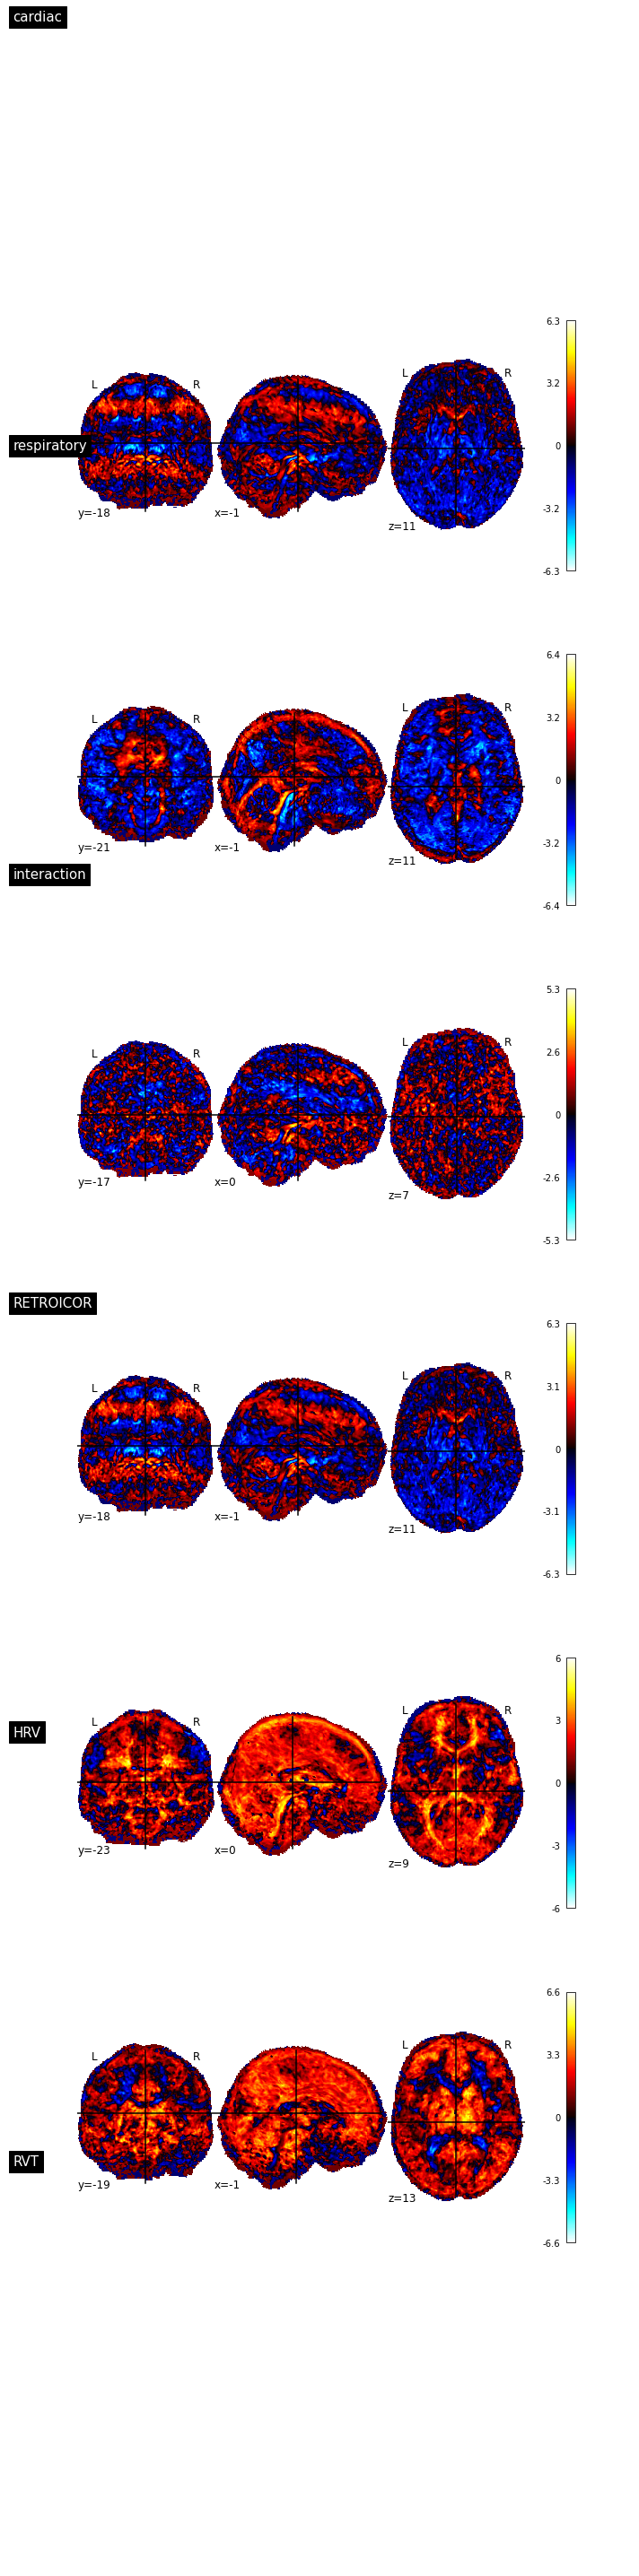

In [208]:
f, ax = plt.subplots(6,1, figsize=(10,40))
for i, contrast_name in enumerate(['cardiac', 'respiratory', 'interaction', 'RETROICOR', 'HRV', 'RVT']):
    slm = fit_second_level_model(contrast_name, df)
    z_map = slm.compute_contrast('intercept', output_type='z_score')
    plotting.plot_stat_map(z_map, axes=ax[i], title=contrast_name)
f.tight_layout()

## With 4.5 mm smoothing

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


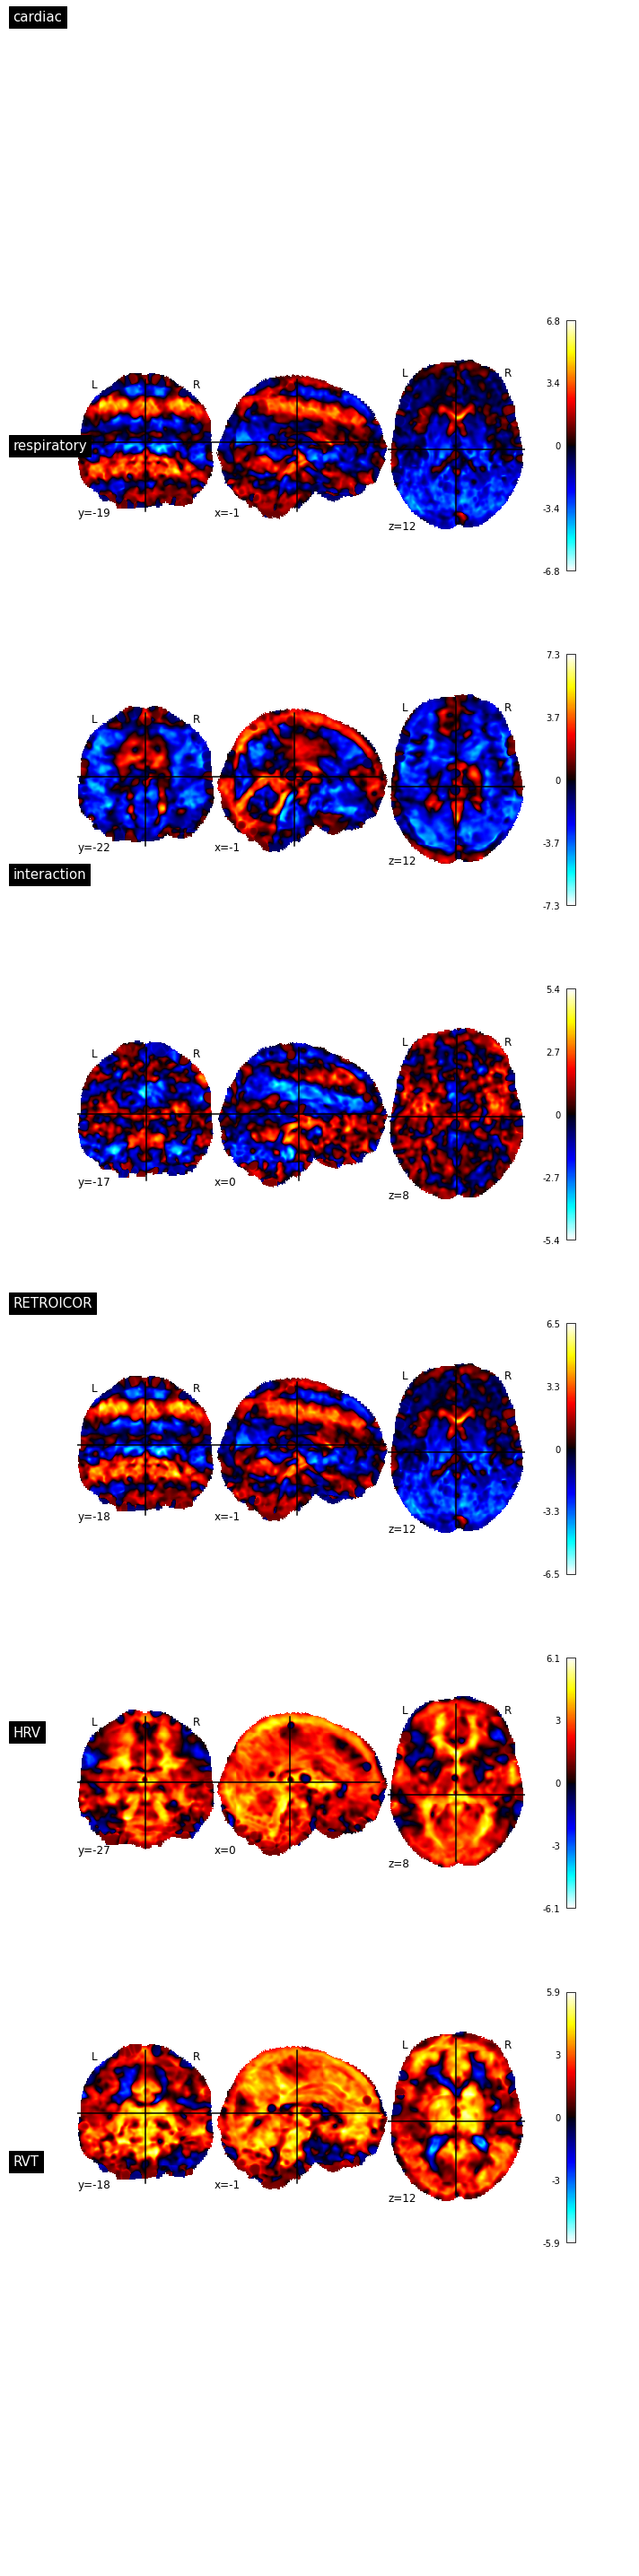

In [209]:
f, ax = plt.subplots(6,1, figsize=(10,40))
for i, contrast_name in enumerate(['cardiac', 'respiratory', 'interaction', 'RETROICOR', 'HRV', 'RVT']):
    slm = fit_second_level_model(contrast_name, df, fwhm=4.5)
    z_map = slm.compute_contrast('intercept', output_type='z_score')
    plotting.plot_stat_map(z_map, axes=ax[i], title=contrast_name)
f.tight_layout()

In [205]:
del flms

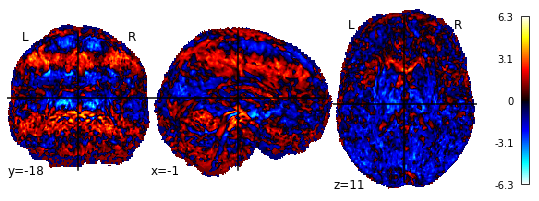

In [195]:
slm_retroicor = fit_second_level_model('RETROICOR', df)
z_map_retroicor = slm_retroicor.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_retroicor)

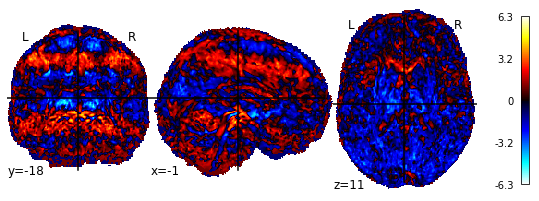

In [196]:
slm_cardiac = fit_second_level_model('cardiac', df)
z_map_cardiac = slm_cardiac.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_cardiac)

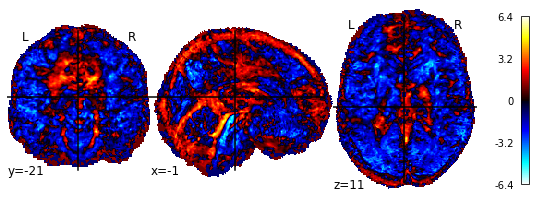

In [193]:
slm_respiratory = fit_second_level_model('respiratory', df)
z_map_respiratory = slm_respiratory.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_respiratory)

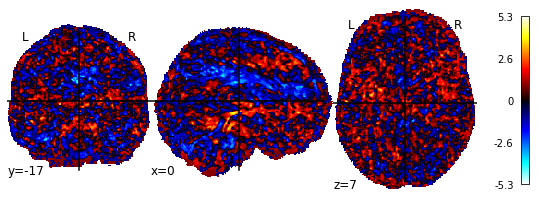

In [194]:
slm_interaction = fit_second_level_model('interaction', df)
z_map_interaction = slm_interaction.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_interaction)

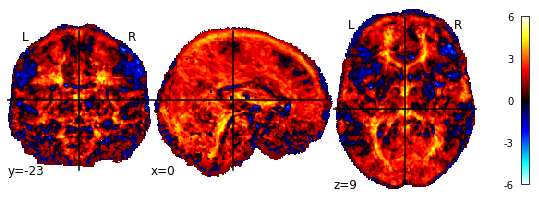

In [197]:
slm_HRV = fit_second_level_model('HRV', df)
z_map_HRV = slm_HRV.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_HRV)

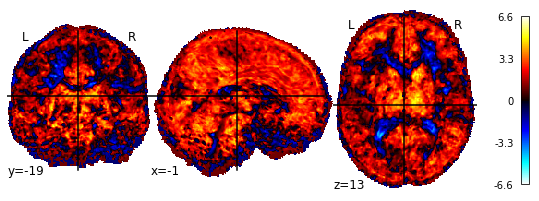

In [198]:
slm_RVT = fit_second_level_model('RVT', df)
z_map_RVT = slm_RVT.compute_contrast('intercept', output_type='z_score')
plotting.plot_stat_map(z_map_RVT)

In [170]:
def save_second_level_spm(spm, first_level_contrast_name, second_level_contrast_name, fwhm, save_dir_name='../derivatives/glm_nilearn_retroicor/group_level_model/ses-anatomical'):
    fwhm = str(fwhm).replace('.', 'p')
    save_fn = os.path.join(save_dir_name, f'fwhm-{fwhm}/firstlevelcontrast-{first_level_contrast_name}_secondlevelcontrast-{second_level_contrast_name}.nii.gz')
    
    if not os.path.exists(os.path.dirname(save_fn)):
        os.makedirs(os.path.dirname(save_fn))
    
    spm.to_filename(save_fn)
    nilearn.image.math_img('-nii', nii=spm).to_filename(save_fn.replace('.nii.gz', '-neg.nii.gz'))
    
def fit_second_level_models(first_level_contrast, second_level_contrast, fwhm, df):
    print(f'{fwhm} {model_n} {first_level_contrast}')
    dm = df.loc[(df.map_name==first_level_contrast) & (df.fwhm==str(fwhm).replace('.', 'p'))].copy()
    #dm = pd.merge(df_in, parameters[['subject_label', 'B0.SPD-ACC_z']]) #, 'V0.SPD-ACC_z']])
    dm['intercept'] = 1

#     if first_level_contrast == 'SPD-ACC':
#         dm_in = dm[['intercept', 'B0.SPD-ACC_z']] #, 'V0.SPD-ACC_z']]
#     else:
    dm_in = dm[['intercept']]
    
    slm = SecondLevelModel()
    slm_fitted = slm.fit(second_level_input=df_in.effects_map_path.values.tolist(), design_matrix=dm_in)

    # Intercept, threshold covariance, urgency covariance
    cmap = slm_fitted.compute_contrast('intercept', output_type='z_score')
    save_second_level_spm(cmap, first_level_contrast_name=first_level_contrast, second_level_contrast_name=second_level_contrast, fwhm=fwhm)

In [172]:
df.map_name.unique()

array(['HRV', 'RETROICOR', 'RVT', 'cardiac', 'interaction', 'respiratory'],
      dtype=object)

In [175]:
import itertools
all_combs = list(itertools.product(df.map_name.unique().tolist(), ['intercept'], [0]))
all_combs

_ = joblib.Parallel(n_jobs=10, verbose=1)(joblib.delayed(fit_second_level_models)(first_level_contrast, second_level_contrast, fwhm, df=df) for first_level_contrast,second_level_contrast,fwhm in all_combs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


TypeError: fit_second_level_models() missing 1 required positional argument: 'parameters'

In [153]:
z1 = slm.compute_contrast(first_level_contrast=contrasts['cardiac'])

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:576: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/glm/contrasts.py:352: UserWarning: Running approximate fixed effects on F statistics.
  warn('Running approximate fixed effects on F statistics.')


ValueError: Field of view of image #1 is different from reference FOV.
Reference affine:
array([[  1.5       ,   0.        ,   0.        , -66.08146667],
       [  0.        ,   1.5       ,   0.        , -86.61924744],
       [  0.        ,   0.        ,   1.5       , -71.01078033],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
Image affine:
array([[  1.5       ,   0.        ,   0.        , -67.697258  ],
       [  0.        ,   1.5       ,   0.        , -85.34696198],
       [  0.        ,   0.        ,   1.5       , -66.86791992],
       [  0.        ,   0.        ,   0.        ,   1.        ]])
Reference shape:
(90, 118, 95)
Image shape:
(93, 121, 95, 1)


In [ ]:
plotting.plot_stat_map(z1)

In [15]:
def fit_retroicor_glm(sub, ses, task, return_glm=False):
    funcs = []
    dms = []
    func_fns = sorted(glob.glob('../derivatives/high_passed_func/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_space-T1w_desc-preproc_bold.nii.gz'.format(sub=sub, ses=ses, task=task)))
    for run, func_fn in enumerate(func_fns):
        retroicor_fn = func_fn.replace('high_passed_func', 'retroicor').replace('_space-T1w_desc-preproc_bold.nii.gz', '_desc-retroicor_regressors.tsv')

        ## load func
        func = nib.load(func_fn)
        retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
        retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']

#         # add cosines  # nope, let's use the high-passed data so we can get a R^2 estimate for the physiological noise only
#         design_matrix = pd.concat([retroicor, make_cosine_matrix(func)], 1)
        retroicor['intercept'] = 1    
        design_matrix = retroicor
#         plot_design_matrix(design_matrix)
        funcs.append(func)
        dms.append(design_matrix)
    
    brain_mask = func_fns[0].replace('_desc-preproc_bold.nii.gz', '_desc-brain_mask.nii.gz').replace('high_passed_func', 'fmriprep/fmriprep')
    print('Fitting GLM for sub {} ses {} task {} ({} runs)...'.format(sub, ses, task, len(func_fns)), end='')
    
    # NB; minimize_memory=False saves the model per voxel so we can get R2 estimates to plot
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, smoothing_fwhm=4.5, mask_img=brain_mask, n_jobs=10, minimize_memory=False)    # lekker smoothen
    flm_fitted = flm.fit(funcs, design_matrices=dms)

    # define & plot contrasts
    simple_contrasts = np.eye(dms[0].shape[1])
    contrasts = {'cardiac': simple_contrasts[:6,:],
                 'respiratory': simple_contrasts[6:(6+8),:],
                 'interaction': simple_contrasts[(6+8):(6+8+4),:],
                 'HRV': simple_contrasts[18,:],
                 'RVT': simple_contrasts[19,:],
                 }

    print('plotting...')
    vmaxes = {'cardiac': 37, 'respiratory': 30, 'interaction': 15, 'HRV': 10, 'RVT': 8}
    templ = '../sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

    f, ax = plt.subplots(6,3, figsize=(12,15), gridspec_kw={'hspace': 0, 'wspace': 0})
    for i, (contrast_name, c_) in enumerate(contrasts.items()):
        z_map_ftest = flm_fitted.compute_contrast(
                               c_,
                               stat_type='F',
                               output_type='z_score')
        vmax = vmaxes[contrast_name]
        
        # warp to MNI
        z_map_ftest = apply_warp(z_map_ftest, sub=sub)
        
        plotting.plot_stat_map(z_map_ftest, bg_img=nib.load(templ), vmax=vmax, title=contrast_name, display_mode='x', cut_coords=[3], axes=ax[i,0], colorbar=False)
        plotting.plot_stat_map(z_map_ftest, bg_img=nib.load(templ), vmax=vmax, display_mode='y', cut_coords=[-3], axes=ax[i,1], colorbar=False)
        plotting.plot_stat_map(z_map_ftest, bg_img=nib.load(templ), vmax=vmax, display_mode='z', cut_coords=[15], axes=ax[i,2])
        os.remove(z_map_ftest) # cleanup
    
    # plot
    r2_nii = flm_fitted.r_square[0]
    r2_nii = apply_warp(r2_nii, sub=sub) # warp to MNI
    plotting.plot_stat_map(r2_nii, bg_img=nib.load(templ), vmax=0.6, title='R^2', display_mode='x', cut_coords=[3], axes=ax[-1,0], colorbar=False)
    plotting.plot_stat_map(r2_nii, bg_img=nib.load(templ), vmax=0.6, display_mode='y', cut_coords=[-3], axes=ax[-1,1], colorbar=False)
    plotting.plot_stat_map(r2_nii, bg_img=nib.load(templ), vmax=0.6, display_mode='z', cut_coords=[15], axes=ax[-1,2])
    os.remove(r2_nii) # cleanup
    
    plot_fn = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-retroicor_glm_SPMs.pdf'.format(sub=sub, ses=ses, task=task)
    os.makedirs(os.path.dirname(plot_fn), exist_ok=True)
#     plot_fn = retroicor_fn.replace('_desc-retroicor_regressors.tsv', '_retroicor-glm.pdf').replace('_run-2', '').replace('_run-1', '').replace('_run-3', '')
    f.savefig(plot_fn, bbox_inches='tight')
    
    if return_glm:
        return flm_fitted
    else:
        del flm_fitted
        return 0

In [111]:
def find_all_to_run(return_tuple=False):
    # if you want to run everything...
    all_retroicor_regressors = sorted(glob.glob('../derivatives/retroicor/sub-*/ses-*/func/*retroicor_regressors.tsv'))
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_desc-retroicor_regressors.tsv')
    all_retroicor_regressors_dict = [regex.match(x).groupdict() for x in all_retroicor_regressors]
    all_retroicor_regressors_df = pd.DataFrame.from_dict(all_retroicor_regressors_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_retroicor_regressors_df.to_dict(orient='records')
    if return_tuple:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    # ie returns the tuples corresponding to subjects for which fit_retroicor_glm hasn't been run yet
    all_retroicor_regressors = find_all_to_run()
    
    to_run = []
    for dict_ in all_retroicor_regressors:
        fp = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-retroicor_glm_SPMs.pdf'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

find_which_to_run()

[('007', 'sstmsit', 'msit'),
 ('010', 'rlsat', 'rlsat'),
 ('012', 'rbrevl', 'rb'),
 ('012', 'rbrevl', 'revl'),
 ('014', 'sstmsit', 'msit'),
 ('014', 'sstmsit', 'sst'),
 ('015', 'rlsat', 'rlsat'),
 ('018', 'rbrevl', 'rb'),
 ('018', 'rlsat', 'rlsat'),
 ('018', 'sstmsit', 'sst'),
 ('019', 'rbrevl', 'revl'),
 ('021', 'anatomical', 'rs'),
 ('021', 'sstmsit', 'msit'),
 ('021', 'sstmsit', 'sst'),
 ('023', 'anatomical', 'rs'),
 ('023', 'rbrevl', 'rb'),
 ('023', 'rbrevl', 'revl'),
 ('023', 'rlsat', 'rlsat'),
 ('023', 'sstmsit', 'msit'),
 ('023', 'sstmsit', 'sst'),
 ('024', 'anatomical', 'rs'),
 ('024', 'rlsat', 'rlsat'),
 ('024', 'sstmsit', 'msit'),
 ('024', 'sstmsit', 'sst'),
 ('025', 'anatomical', 'rs'),
 ('025', 'rbrevl', 'rb'),
 ('025', 'rbrevl', 'revl'),
 ('026', 'anatomical', 'rs'),
 ('026', 'rbrevl', 'rb'),
 ('026', 'rbrevl', 'revl'),
 ('026', 'rlsat', 'rlsat'),
 ('026', 'sstmsit', 'msit'),
 ('026', 'sstmsit', 'sst'),
 ('027', 'anatomical', 'rs'),
 ('029', 'anatomical', 'rs'),
 ('029', '

In [53]:
to_run = find_which_to_run()
#to_run = find_all_to_run(True)

# to_run = [('002', 'anatomical', 'rs'),
#  ('003', 'rlsat', 'rlsat'),
#  ('005', 'sstmsit', 'msit'),
#  ('005', 'sstmsit', 'sst'),
# # ('007', 'rlsat', 'rlsat'),
#  ('009', 'anatomical', 'rs'),
#  ('009', 'sstmsit', 'msit'),
#  ('009', 'sstmsit', 'sst'),
#  ('010', 'anatomical', 'rs'),
#  ('011', 'anatomical', 'rs'),
#  ('011', 'rlsat', 'rlsat')]

# print(to_run)

# beware memory load
#Parallel(n_jobs=8, verbose=1)(delayed(fit_retroicor_glm)(sub, ses, task) for sub, ses, task in to_run)

def fit_retroicor_glm_catch(sub,ses,task):
    try:
        fit_retroicor_glm(sub,ses,task)
    except:
        print('{} {} {} FAILED'.format(sub,ses,task))
        return 1
    
## with catch
Parallel(n_jobs=5, verbose=1)(delayed(fit_retroicor_glm_catch)(sub, ses, task) for sub, ses, task in to_run)

# for sub,ses,task in to_run:
#     print(sub,ses,task)
#     try:
#         fit_retroicor_glm(sub,ses,task)
#     except:
#         print('FAILED: ')
#         print(sys.exc_info()[0])

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:  9.7min finished


[1, 1, None, None, None, None, 1, 1, 1]

In [54]:
find_which_to_run()

[('007', 'sstmsit', 'msit'),
 ('010', 'rlsat', 'rlsat'),
 ('018', 'rlsat', 'rlsat'),
 ('018', 'sstmsit', 'sst'),
 ('019', 'rbrevl', 'revl')]

# 3. Left > Right motor response (only for non-RS, obviously)

In [ ]:
def plot_responsehand_glms(glms, sub, x=34, y=-20, z=58):
    zs = [x.compute_contrast('response_left - response_right') for x in glms]
    
    templ = '../sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

    contrast_name = 'left>right'
    n_runs = len(zs)
    f, ax = plt.subplots(n_runs,3, figsize=(12, n_runs*2), gridspec_kw={'hspace': 0, 'wspace': 0})
    
    if n_runs > 1:
        for run in range(n_runs-1):
            # warp z-map to mni
            z_map = zs[run]
            z_map = apply_warp(z_map, sub=sub)
            
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), title='Run {}'.format(run+1), display_mode='x', cut_coords=[x], axes=ax[run,0], colorbar=False)
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='y', cut_coords=[y], axes=ax[run,1], colorbar=False)
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='z', cut_coords=[z], axes=ax[run,2])
            os.remove(z_map) # clean-up
    
    run = n_runs-1
    z_map = zs[run]
    z_map = apply_warp(z_map, sub=sub)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), title='Fixed effects across runs', display_mode='x', cut_coords=[x], axes=ax[run,0], colorbar=False)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='y', cut_coords=[y], axes=ax[run,1], colorbar=False)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='z', cut_coords=[z], axes=ax[run,2])
    os.remove(z_map)
    return f, ax

def fit_responsehand_glm(sub, ses, task, include_physio=True, per_run=True, return_glms=False):
    event_fns = sorted(glob.glob('../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_events.tsv'.format(sub=sub, ses=ses, task=task)))
    run_flms = []
    run_events = []
    run_funcs = []
    run_confounds = []

    for run, event_fn in enumerate(event_fns):
        run += 1
        events = pd.read_csv(event_fn, sep='\t', index_col=None)
        events = events.loc[events.trial_type.isin(['response_left', 'response_right'])] 
        events['duration'] = 0.001
        run_events.append(events)

        ## load func
        func_fn = '../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'.format(sub=sub, ses=ses, task=task, run=run)
        brain_mask = func_fn.replace('desc-preproc_bold', 'desc-brain_mask')
        func = nib.load(func_fn)
        run_funcs.append(func)
        
        if include_physio:
            ## load confounds
            retroicor_fn = func_fn.replace('fmriprep/fmriprep', 'retroicor').replace('_space-T1w_desc-preproc_bold.nii.gz', '_desc-retroicor_regressors.tsv')
            retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
            retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
        else:
            retroicor=None
        
        run_confounds.append(retroicor)
        
        # fit run-level model
        if per_run:
            flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, mask_img=brain_mask, smoothing_fwhm=4.5, n_jobs=20)  # lekker smoothen
            flm_fitted = flm.fit(func, events=events, confounds=retroicor)
            run_flms.append(flm_fitted)
        
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, mask_img=brain_mask, smoothing_fwhm=4.5, n_jobs=20)  # lekker smoothen
    flm_fitted = flm.fit(run_funcs, events=run_events, confounds=run_confounds if include_physio else None)
    run_flms.append(flm_fitted)
    
    f, ax = plot_responsehand_glms(run_flms, sub)
    plot_fn = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-motor_contrast_glm_SPMs.pdf'.format(sub=sub, ses=ses, task=task)
#     plot_fn = event_fns[0].replace('event_files', 'quality_control_plots').replace('_events.tsv', '_desc-motor_contrast.pdf')
    os.makedirs(os.path.dirname(plot_fn), exist_ok=True)
    f.savefig(plot_fn)
    
    if return_glms:
        return run_flms
    else:
        del run_flms
        return 0
    
def plot_responsefinger_glms(glms, response_contrast, sub, x=34, y=-20, z=58):
    
    #for response_contrast in ['response_index - response_middle', 'response_index - response_ring', 'response_ring - response_middle']
    
    #zs = [x.compute_contrast('response_index - response_middle') for x in glms]
    zs = [x.compute_contrast(response_contrast) for x in glms]

    templ = '../sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

    contrast_name = 'index>middle'
    n_runs = len(zs)
    f, ax = plt.subplots(n_runs,3, figsize=(12, n_runs*2), gridspec_kw={'hspace': 0, 'wspace': 0})

    if n_runs > 1:
        for run in range(n_runs-1):
            z_map = zs[run]
            z_map = apply_warp(z_map, sub=sub)

            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), title='Run {}'.format(run+1), display_mode='x', cut_coords=[x], axes=ax[run,0], colorbar=False)
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='y', cut_coords=[y], axes=ax[run,1], colorbar=False)
            plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='z', cut_coords=[z], axes=ax[run,2])
            os.remove(z_map)
            
    run = n_runs-1
    z_map = zs[run]
    z_map = apply_warp(z_map, sub=sub)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), title='Fixed effects across runs', display_mode='x', cut_coords=[x], axes=ax[run,0], colorbar=False)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='y', cut_coords=[y], axes=ax[run,1], colorbar=False)
    plotting.plot_stat_map(z_map, bg_img=nib.load(templ), display_mode='z', cut_coords=[z], axes=ax[run,2])
    os.remove(z_map)
    return f, ax

def fit_responsefinger_glm(sub, ses, task, include_physio=True, per_run=True, return_glms=False):
    
    event_fns = sorted(glob.glob('../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-*_events.tsv'.format(sub=sub, ses=ses, task=task)))
    run_flms = []
    run_events = []
    run_funcs = []
    run_confounds = []

    for run, event_fn in enumerate(event_fns):
        run += 1
        events = pd.read_csv(event_fn, sep='\t', index_col=None)
        events = events.loc[events.trial_type.isin(['response_index', 'response_middle','response_ring'])] 
        events['duration'] = 0.001
        run_events.append(events)

        ## load func
        func_fn = '../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz'.format(sub=sub, ses=ses, task=task, run=run)
        brain_mask = func_fn.replace('desc-preproc_bold', 'desc-brain_mask')
        func = nib.load(func_fn)
        run_funcs.append(func)
        
        if include_physio:
            ## load confounds
            retroicor_fn = func_fn.replace('fmriprep/fmriprep', 'retroicor').replace('_space-T1w_desc-preproc_bold.nii.gz', '_desc-retroicor_regressors.tsv')
            retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
            retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
        else:
            retroicor=None
        
        run_confounds.append(retroicor)
        
        # fit run-level model
        if per_run:
            flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, mask_img=brain_mask, smoothing_fwhm=4.5, n_jobs=20)  # lekker smoothen
            flm_fitted = flm.fit(func, events=events, confounds=retroicor)
            run_flms.append(flm_fitted)
        
    flm = FirstLevelModel(t_r=1.38, slice_time_ref=0.5, mask_img=brain_mask, smoothing_fwhm=4.5, n_jobs=20)  # lekker smoothen
    flm_fitted = flm.fit(run_funcs, events=run_events, confounds=run_confounds if include_physio else None)
    run_flms.append(flm_fitted)
    
    for response_contrast, save_contrast in zip(['response_index - response_middle', 'response_index - response_ring', 'response_ring - response_middle'],['IminM','IminR','RminM']):
        f, ax = plot_responsefinger_glms(run_flms, response_contrast, sub)
        plot_fn = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-motor_contrast-{save_contrast}_glm_SPMs.pdf'.format(sub=sub, ses=ses, task=task, save_contrast=save_contrast)
    #     plot_fn = event_fns[0].replace('event_files', 'quality_control_plots').replace('_events.tsv', '_desc-motor_contrast.pdf')
        os.makedirs(os.path.dirname(plot_fn), exist_ok=True)
        f.savefig(plot_fn)
    
    if return_glms:
        return run_flms
    else:
        del run_flms
        return 0

## Non-MSIT

In [ ]:
def find_all_to_run_nonmsit(return_tuple=False):
    # if you want to run everything...
    all_event_files = sorted(glob.glob('../derivatives/event_files/sub-*/ses-*/func/sub-*_ses-*_task-*_run-*_events.tsv'))
    all_event_files = [x for x in all_event_files if not 'task-msit' in x]
    
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_events.tsv')
    all_event_files_dict = [regex.match(x).groupdict() for x in all_event_files]
    all_event_files_df = pd.DataFrame.from_dict(all_event_files_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_event_files_df.to_dict(orient='records')
    if return_tuple:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run_nonmsit():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    # ie returns the tuples corresponding to subjects for which fit_retroicor_glm hasn't been run yet
    all_event_files = find_all_to_run_nonmsit()
    
    to_run = []
    for dict_ in all_event_files:
        fp = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-motor_contrast_glm_SPMs.pdf'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

In [ ]:
to_run = find_all_to_run_nonmsit(True)
to_run = find_which_to_run_nonmsit()
print(to_run)

## joblib, also here careful with n_jobs
Parallel(n_jobs=10, verbose=1)(delayed(fit_responsehand_glm)(sub, ses, task) for sub, ses, task in to_run)

## MSIT

In [97]:
def find_all_to_run_msit(return_tuple=False):
    # if you want to run everything...
    all_event_files = sorted(glob.glob('../derivatives/event_files/sub-*/ses-*/func/sub-*_ses-*_task-msit_run-*_events.tsv'))
    
    regex = re.compile('.*sub-(?P<sub>\d+)/ses-(?P<ses>\S+)/func/sub-.*_ses-.*_task-(?P<task>\S+)_run-.*_events.tsv')
    all_event_files_dict = [regex.match(x).groupdict() for x in all_event_files]
    all_event_files_df = pd.DataFrame.from_dict(all_event_files_dict).sort_values(['sub','ses','task']).drop_duplicates()
    
    dict_list = all_event_files_df.to_dict(orient='records')
    if return_tuple:
        return [tuple(x.values()) for x in dict_list]
    else:
        return dict_list

def find_which_to_run_msit():
    # finds all runs for which there are RETROICOR regressors, and removes those for which there's an output already
    # ie returns the tuples corresponding to subjects for which fit_retroicor_glm hasn't been run yet
    all_event_files = find_all_to_run_msit()
    
    to_run = []
    for dict_ in all_event_files:
        fp = '../derivatives/quality_control_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_desc-motor_contrast-IminM_glm_SPMs.pdf'.format(**dict_)
        if not os.path.exists(fp):
#             print('{} doesnt exist'.format(fp))
            to_run.append(dict_)
    return [tuple(x.values()) for x in to_run]

In [98]:
to_run = find_all_to_run_msit(True) #[('003', 'sstmsit', 'msit')]
print(to_run)
# to_fit = [('003', 'sstmsit', 'msit')]

## joblib, also here careful with n_jobs
Parallel(n_jobs=4, verbose=1)(delayed(fit_responsefinger_glm)(sub, ses, task) for sub, ses, task in to_run)

[('002', 'sstmsit', 'msit'), ('003', 'sstmsit', 'msit'), ('004', 'sstmsit', 'msit'), ('006', 'sstmsit', 'msit')]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.4min remaining:  8.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.6min finished


[0, 0, 0, 0]

In [14]:
_ = pd.read_csv('/home/Public/trondheim/derivatives/phys_log/sub-057/ses-grids/func/sub-057_ses-grids_task-grids_run-3_Info.log', sep=',')

In [18]:
!cat '/home/Public/trondheim/derivatives/phys_log/sub-057/ses-grids/func/sub-057_ses-grids_task-grids_run-3_RESP.log'

UUID        = 68f7819d-7970-4df7-82a9-ee7c31f43b4a
ScanDate    = 20221206_164251
LogVersion  = EJA_1
LogDataType = RESP
SampleTime  = 8

ACQ_TIME_TICS  CHANNEL  VALUE  SIGNAL

     24076820     RESP   1091 
     24076828     RESP   1047 
     24076836     RESP   1018 
     24076844     RESP    975 
     24076852     RESP    946 
     24076859     RESP    859 
     24076867     RESP    801 
     24076875     RESP    757 
     24076883     RESP    728 
     24076891     RESP    699 
     24076899     RESP    685 
     24076907     RESP    728 
     24076915     RESP    844 
     24076923     RESP    960 
     24076931     RESP   1033 
     24076939     RESP   1076 
     24076947     RESP   1105 
     24076955     RESP   1149 
     24076963     RESP   1207 
     24076971     RESP   1250 
     24076979     RESP   1250 
     24076987     RESP   1279 
     24076995     RESP   1323 
     24077003     RESP   1395 
     24077011     RESP   1511 
     24077019     RESP   1656 
     24077027     

## 